# Paper plots
> We take the data generated in the analysis and plot it nicely for the paper. Here, you can find the source code to generate all the plots as they appear in the paper.

In [ ]:
#| hide
import pickle
import matplotlib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from step.data import DATA_PATH, FIG_PATH, MODEL_DATA

In [ ]:
with open(Path('colors_dict.pkl'), 'rb') as f:
    color_dict = pickle.load(f)

color_order = ['blue', 'orange', 'yellow', 'purple', 'green']
colors = [color_dict[k]['medium'] for k in color_order]
colors_light = [color_dict[k]['light'] for k in color_order]
colors_dark = [color_dict[k]['dark'] for k in color_order]

import matplotlib.colors as clr
cmap_hist1 = clr.LinearSegmentedColormap.from_list('custom cm', ['w',
                                                                 color_dict['blue']['light'],
                                                                 color_dict['blue']['dark']], N=256)
cmap_hist2 = clr.LinearSegmentedColormap.from_list('custom cm', ['w',
                                                                 color_dict['orange']['light'],
                                                                 color_dict['orange']['dark']], N=256)
cmap_points = clr.LinearSegmentedColormap.from_list('custom cm', [color_dict['yellow']['light'],
                                                                  color_dict['purple']['light'],
                                                                  color_dict['blue']['medium']], N=256)

fig_size = 4
linewidth = 2
alpha_grid = 0.2
scatter_size = 12

D_units = "($\mu$m$^2$/s)"

# Benchmarking on simulated trajectories

We validate the predictions of the presented model over simulated trajectories. This allows us to compare them to the known ground truth and consider various factors that can have an impact on its performance.

## Point-wise prediction

We perform an exhaustive analysis combining data from various tasks, which we have to process differently.

### Diffusion coefficient error
#### Prediction vs true value

We start by loading the data. This is quite heavyweight so it takes a good couple of minutes to load. We have a ton of predictions!

In [ ]:
with open(DATA_PATH/"segment_analysis_test.pkl", 'rb') as f:
    big_ds = pickle.load(f)

In [ ]:
true = np.concatenate([*big_ds.y])
pred = np.concatenate([*big_ds.pred_cut])

In [ ]:
hist, true_edges, pred_edges = np.histogram2d(true, pred, bins=[np.linspace(-3, 3, 61), np.linspace(-3.1, 3.1, 63)])

#### Relative error as function of segment length

First of all, we load the data. In this case, there is not much pre-processing to do, as we have already saved the metrics of interest. 

In [ ]:
with open(FIG_PATH/'relative_error_segment_length.pkl', 'rb') as f:
    metric_by_length_D = pickle.load(f)

In [ ]:
print(f"STEP: {metric_by_length_D['err']['global']:.3f}")
print(f"STEP + segments: {metric_by_length_D['err_segment']['global']:.3f}")
print(f"TA-MSD + segments: {metric_by_length_D['err_tmsd']['global']:.3f}")

STEP: 0.226
STEP + segments: 0.189
TA-MSD + segments: 0.342


We find the points for which the segment lengths match with the ones in subfigure (b). We will highlight those to ease the visual comparison.

In [ ]:
lengths = np.arange(10, 191)
segment_lengths = np.array([20, 40, 60])
highlight_idx = [int(np.argwhere(lengths==l).flatten()) for l in segment_lengths]

### Anomalous exponent

#### Prediction vs true value for FBM trajectories

In [ ]:
fig_name = "pred_vs_true_models"
with open(FIG_PATH/f'{fig_name}.pkl', 'rb') as f:
    pred_vs_true_by_model, noise_ranges, bins_by_model = pickle.load(f)

In [ ]:
hist_fbm, true_edges_fbm, pred_edges_fbm = list(pred_vs_true_by_model['fbm'].values())

#### Prediction error as function of segment length

In [ ]:
figure_name = "mae_segment_length_noise_ctrw"
plot_data_path = (FIG_PATH/figure_name).with_suffix(".pkl")

with open(plot_data_path, 'rb') as f:
    metric_by_length_a = pickle.load(f)

In [ ]:
condor_path = FIG_PATH/"CONDOR_preds_true_lengths_noise.npy"
condor_data = np.load(condor_path) # preds, true, lengths, noises

In [ ]:
condor_error = np.abs(condor_data[0] - condor_data[1])

In [ ]:
from scipy.stats import sem

bin_size = 10
condor_x = np.arange(10, 190, bin_size) + bin_size/2
condor_mae_length = np.array([condor_error[(condor_data[2] >= l) & (condor_data[2] < l + bin_size)].mean()
                              for l in range(10, 190, bin_size)])
condor_sem_length = np.array([sem(condor_error[(condor_data[2] >= l) & (condor_data[2] < l + bin_size)])
                              for l in range(10, 190, bin_size)])

condor_noises = [0.1, 0.5, 1.]
condor_mae_noise = np.array([condor_error[(condor_data[2] < 190) & (condor_data[3] == n)].mean()
                             for n in condor_noises])
condor_sem_noise = np.array([sem(condor_error[(condor_data[2] < 190) & (condor_data[3] == n)])
                             for n in condor_noises])

### Plot point-wise prediction metrics

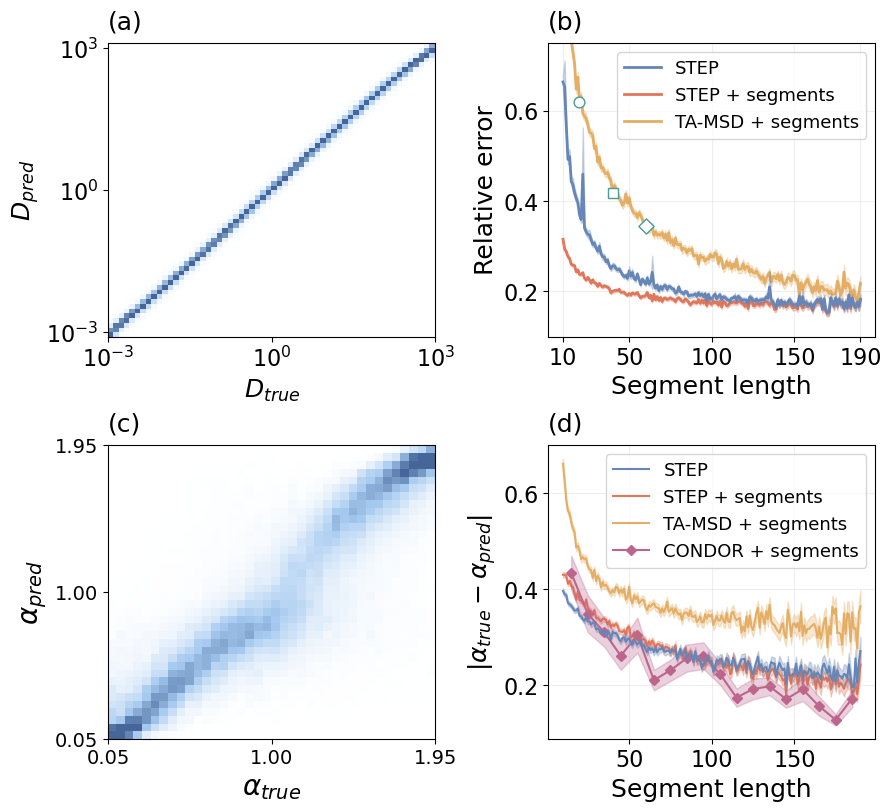

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(2.2*fig_size, 2*fig_size), constrained_layout=True)
fontsize = 18
ticksize = 16

# PRED D vs TRUE D
axes[0][0].pcolor(hist.transpose()/hist.max(), cmap=cmap_hist1, vmax=0.8, rasterized=True)
# axes[0][0].plot(np.arange(hist.shape[-1] - 1), np.arange(hist.shape[-1] - 1) + 1,
#                 linewidth=2.5, color=colors[3])
xtick_pos = np.linspace(0, len(true_edges) - 1, np.ceil(len(true_edges)/30).astype(int))
xtick_labels = [fr'$10^{{{i:.0f}}}$' for i in true_edges[::30]]
ytick_pos = np.linspace(0, len(pred_edges) - 3, np.ceil(len(pred_edges)/30).astype(int)) + 1
ytick_labels = [fr'$10^{{{i:.0f}}}$' for i in pred_edges[1::30]]
axes[0][0].set_yticks(ytick_pos, labels=ytick_labels)
axes[0][0].set_ylabel(r'$D_{pred}$', fontsize=fontsize)
axes[0][0].set_xticks(xtick_pos, xtick_labels)
axes[0][0].set_xlabel(r'$D_{true}$', fontsize=fontsize)
axes[0][0].tick_params(labelsize=ticksize)

# D vs SEGMENT LENGTH
labels = ['STEP', 'STEP + segments', 'TA-MSD + segments']
markers = ['o', 's', 'D']

for i, m in enumerate(metric_by_length_D.keys()): 
    if i%2 != 0: continue
    mean, sem = metric_by_length_D[m]['mean'], metric_by_length_D[m]['sem']
    label = labels[i//2] 
    zorder = 1 if i == 0 else -1
    axes[0][1].plot(lengths, mean, color=colors[i//2], label=label, zorder=zorder, lw=linewidth)
    axes[0][1].fill_between(lengths, mean - sem, mean + sem, color=colors[i//2], alpha=0.3, zorder=zorder)

axes[0][1].grid(alpha=alpha_grid)
axes[0][1].legend(fontsize=ticksize-3)
axes[0][1].tick_params(labelsize=ticksize)
axes[0][1].set_ylim([0.1, 0.75])
axes[0][1].set_xticks([10, 50, 100, 150, 190])
axes[0][1].set_yticks([0.2, 0.4, 0.6])
axes[0][1].set_xlabel("Segment length", fontsize=fontsize)
axes[0][1].set_ylabel("Relative error", fontsize=fontsize);

for h, h_idx, marker in zip(segment_lengths, highlight_idx, markers):
    axes[0][1].scatter(h, mean[h_idx], zorder=10, marker=marker, facecolor='w', 
                  edgecolor=colors[-1], s=60)

# ALPHA PRED vs TRUE
dwn_smpl = 19
tick_pos = [(np.arange(hist_fbm[0].shape[i]+1))[::dwn_smpl] for i in range(2)]
xtick_label = [f'{v:.2f}' for v in true_edges_fbm[1:-1:dwn_smpl]]
ytick_label = [f'{v:.2f}' for v in pred_edges_fbm[1:-1:dwn_smpl]]

hist_fbm_plot = hist_fbm[0][:-2, 1:-1]
axes[1][0].pcolor(hist_fbm_plot.transpose()/hist_fbm_plot.max(), vmin=0., vmax=0.4,
                  rasterized=True, cmap=cmap_hist1)

# axes[1][0].plot(np.arange(hist_fbm_plot.shape[-1] + 1), np.arange(hist_fbm_plot.shape[-1] + 1),
#                 linewidth=2.5, color=colors[3])
axes[1][0].set_yticks(tick_pos[0], labels=ytick_label)
axes[1][0].set_ylabel(r'$\alpha_{pred}$', fontsize=20)
axes[1][0].set_xticks(tick_pos[1], labels=xtick_label)
axes[1][0].set_xlabel(r'$\alpha_{true}$', fontsize=20)
axes[1][0].tick_params(labelsize=14)

# ALPHA vs SEGMENT LENGTH
lengths = np.arange(10, 191)
labels = ['STEP', 'STEP + segments', 'TA-MSD + segments', 'CONDOR + segments']
marker_condor, marker_size = 'D', 5
for i, m in enumerate(metric_by_length_a.keys()):
    if i%2 == 0:
        mean, sem = metric_by_length_a[m]['mean'], metric_by_length_a[m]['sem']
        label = labels[i//2]# if i%2 == 0 else None
        axes[1][1].plot(lengths, mean, linestyle='-', color=colors[i//2], label=label,
                        zorder=10 if i==0 else -1)
        axes[1][1].fill_between(lengths, mean - sem, mean + sem, color=colors[i//2], alpha=0.3)
axes[1][1].plot(condor_x, condor_mae_length, marker=marker_condor, ms=marker_size,
                color=colors[3], label=labels[-1], zorder=-1)
axes[1][1].fill_between(condor_x, condor_mae_length - condor_sem_length,
                        condor_mae_length + condor_sem_length, color=colors[3], alpha=0.3)
axes[1][1].grid(alpha=alpha_grid)
axes[1][1].legend(fontsize=ticksize-3)
axes[1][1].tick_params(labelsize=ticksize)
axes[0][1].set_ylim([0.1, 0.75])
axes[1][1].set_xlabel("Segment length", fontsize=fontsize)
axes[1][1].set_ylabel(r"$|\alpha_{true} - \alpha_{pred}|$", fontsize=fontsize)

# GENERAL
for ax, letter in zip(axes.ravel(), 'abcd'):
    ax.annotate('('+letter+')', (0, 1.05), xycoords='axes fraction', fontsize=fontsize)
    
# plt.savefig(FIG_PATH/"benchmark_left.pdf", transparent=True, bbox_inches='tight')

##  Detecting changes

Up until now, we have looked at the capability of our method to provide predictions that are close to the actual ground truth. Here, we look at how well it can detect changes in diffusive properties. For this, we use a simple change point detection algorithm implemented with the [ruptures library](https://centre-borelli.github.io/ruptures-docs/). We run this change point detection on the STEP prediction and compare it to other typical classical benchmarks.

Since the algorithm can detect an arbitrary number of change points, we solve a linear sum assignment problem to perform the matching between the ground truth and the prediction. Then, we consider a valid prediction, i.e., a true positive (TP), those change points that lie within a trheshold of their corresponding ground truth. This way, all the predicted change points that are not TP are false positives (FP). Finally, the ground truth change points that do not have a predicted counterpart within the threshold are false negatives (FN). 
To evaluate the change point detection, we use the Jaccard index, which is a function of the TP, FP and FN: $$J = \frac{TP}{TP + FP + FN}\,.$$

### Changes in D

First, we look at how we can detect changes in the diffusion coefficient. These changes naturally appear in the trajectory displacements, provided that they are proportional to $\sqrt{D}$. Thus, we apply the change point detection algorithm to both our predictions and the trajectory displacements. 

In [ ]:
df_path = DATA_PATH/"bmds_1change_dim2_with_preds.pkl"
df_changes_D = pd.read_pickle(df_path)

We will focus on two factors that can impact the model performance: the differences between segments and the change point positions.

#### Differences between segments

It is easy to see that, the larger the difference in D between segments, the easier it becomes to locate the change point.

In [ ]:
from step.utils import jaccard_index

In [ ]:
bins_D_diff = np.linspace(-6, 6, 100)

In [ ]:
methods = ['pred', 'displ']
j_idx_by_D_diff = {m: [] for m in methods}

for low, high in zip(bins_D_diff[:-1], bins_D_diff[1:]):
    mask = (df_changes_D.D_diff >= low) & (df_changes_D.D_diff < high)
    for m in methods:
        tp = df_changes_D.loc[mask, f'cp_{m}_tp'].sum()
        fp = df_changes_D.loc[mask, f'cp_{m}_fp'].sum()
        fn = df_changes_D.loc[mask, f'cp_{m}_fn'].sum()
        j_idx_by_D_diff[m].append(jaccard_index(tp, fp, fn))

Text(0, 0.5, 'Jaccard index')

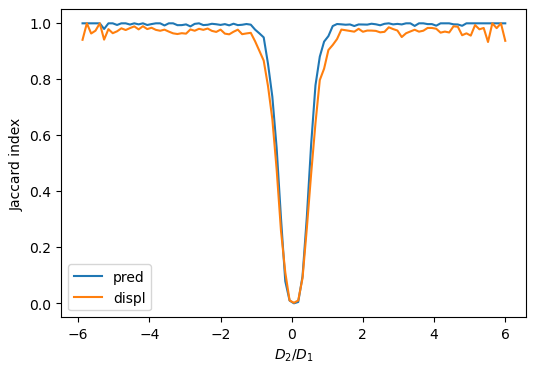

In [ ]:
plt.figure(figsize=(6, 4))
plt_x = bins_D_diff[:-1] + np.diff(bins_D_diff)
for m in methods:
    plt.plot(plt_x, j_idx_by_D_diff[m], label=m)
plt.legend()
plt.xlabel(r"$D_2/D_1$")
plt.ylabel("Jaccard index")

#### Change point location

The change point location also plays a key role in the change point detection. Shorter segments are much harder to characterize and, thus, we expect the performance to drop when the change point is near the trajectory ends.

In [ ]:
bins_cp_pos = np.arange(10, 200, 10)
j_idx_by_position_D = {m: [] for m in methods}
for low, high in zip(bins_cp_pos[:-1], bins_cp_pos[1:]):
    mask = (low <= df_changes_D.cp) & (df_changes_D.cp < high)
    for m in methods:
        tp = df_changes_D.loc[mask, f'cp_{m}_tp'].sum()
        fp = df_changes_D.loc[mask, f'cp_{m}_fp'].sum()
        fn = df_changes_D.loc[mask, f'cp_{m}_fn'].sum()
        j_idx_by_position_D[m].append(jaccard_index(tp, fp, fn))

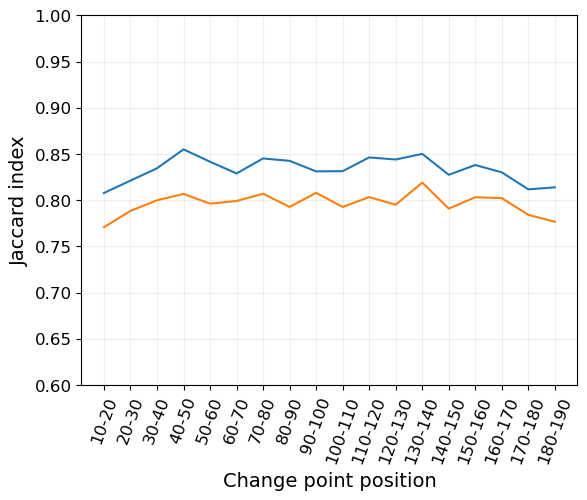

In [ ]:
for m in methods:
    plt.plot(j_idx_by_position_D[m])
plt.xticks(np.arange(len(bins_cp_pos)-1), 
           [f'{low}-{high}' for low, high in zip(bins_cp_pos[:-1], bins_cp_pos[1:])],
           rotation=70);
plt.grid(alpha=0.2)
plt.ylabel("Jaccard index", fontsize=14)
plt.xlabel("Change point position", fontsize=14)
plt.ylim([0.6, 1])
plt.tick_params(labelsize=12);

### Changes in $\alpha$

Analogous to the changes in D, we can study how these methods can be used to detect changes in the anomalous exponent. In this case, we consider FBM trajectories with $\alpha\in[0.05, 1.95]$. However, these changes cannot be detected in the trajectory displacements and, thus, we use a sliding window of 30 time steps to estimate $\alpha$ through a linear fit of the TA-MSD in log-log space.

In [ ]:
df_changes_a = pd.read_pickle(FIG_PATH/"changepoint_detection_alpha_df.pkl")

Again, we look at the differences between segments and the change point position.

#### Differences between segments

We are considering a finite set of $\alpha$, meaning that we can simply take all the possible values of $\alpha_1 - \alpha_0$.

In [ ]:
methods_a = ['pred', 'tamsd']
differences = np.unique(df_changes_a.alpha_diff)
j_idx_by_a_diff = {m: [] for m in methods_a}
for diff in differences:
    mask = df_changes_a.alpha_diff == diff
    for m in methods_a:
        tp = df_changes_a.loc[mask, f'cp_{m}_tp'].sum()
        fp = df_changes_a.loc[mask, f'cp_{m}_fp'].sum()
        fn = df_changes_a.loc[mask, f'cp_{m}_fn'].sum()
        j_idx_by_a_diff[m].append(jaccard_index(tp, fp, fn))

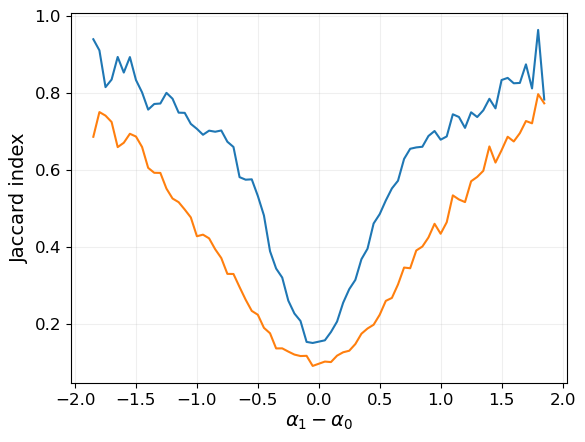

In [ ]:
for m in methods_a:
    plt.plot(differences, j_idx_by_a_diff[m])
plt.grid(alpha=0.2)
plt.xlabel(r"$\alpha_1 - \alpha_0$", fontsize=14)
plt.ylabel("Jaccard index", fontsize=14)
plt.tick_params(labelsize=12);

#### Change point location

In [ ]:
# bins_cp_pos = np.arange(10, 200, 10) # Same as before
j_idx_by_position_a = {m: [] for m in methods_a}
for low, high in zip(bins_cp_pos[:-1], bins_cp_pos[1:]):
    mask = (low <= df_changes_a.cp) & (df_changes_a.cp < high)
    for m in methods_a:
        tp = df_changes_a.loc[mask, f'cp_{m}_tp'].sum()
        fp = df_changes_a.loc[mask, f'cp_{m}_fp'].sum()
        fn = df_changes_a.loc[mask, f'cp_{m}_fn'].sum()
        j_idx_by_position_a[m].append(jaccard_index(tp, fp, fn))

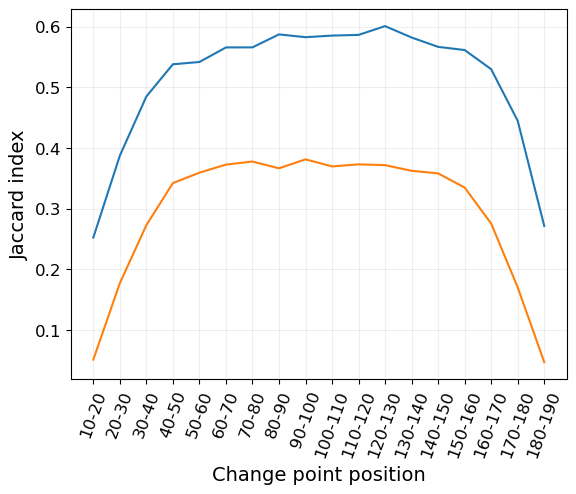

In [ ]:
for m in methods_a:
    plt.plot(j_idx_by_position_a[m])
plt.xticks(np.arange(len(bins_cp_pos)-1), 
           [f'{low}-{high}' for low, high in zip(bins_cp_pos[:-1], bins_cp_pos[1:])],
           rotation=70);
plt.grid(alpha=0.2)
plt.ylabel("Jaccard index", fontsize=14)
plt.xlabel("Change point position", fontsize=14)
plt.tick_params(labelsize=12);

## Plot all together

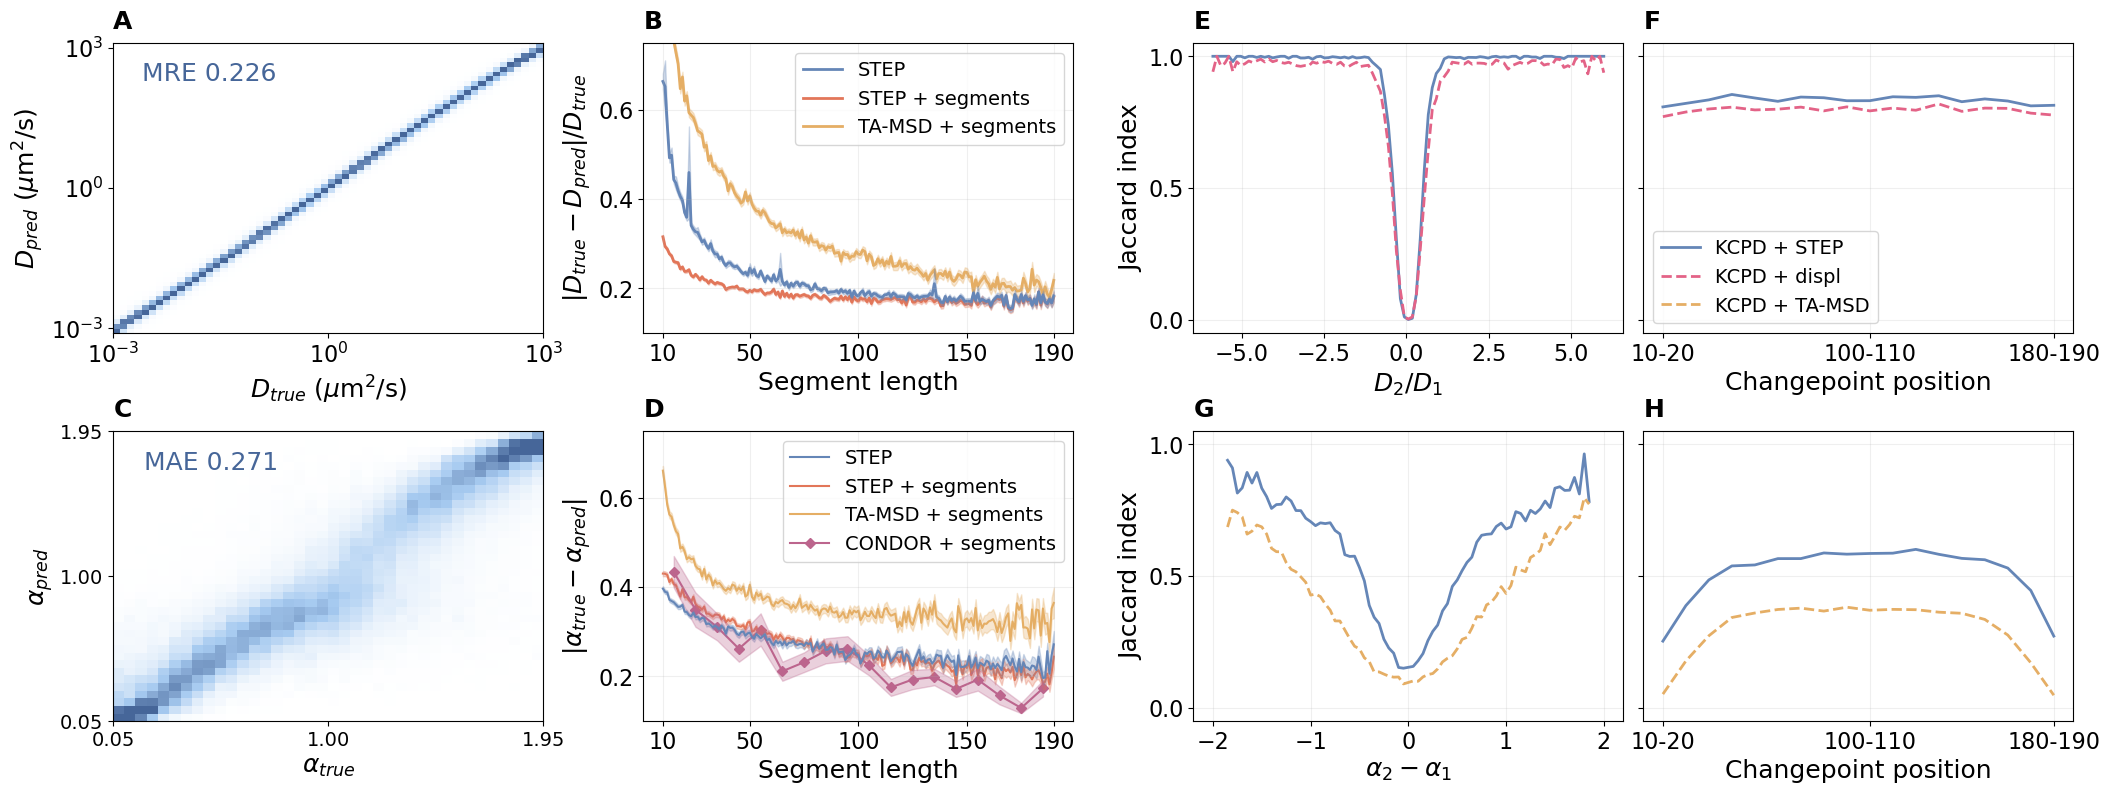

In [ ]:
fig = plt.figure(figsize=(5.*fig_size, 2.2*fig_size))
fontsize = 18
ticksize = 16

v_space_l, v_space_m, v_space_r, os = 0.05, 0.06, 0.01, 0.01
width = (1- 2*os - v_space_l - v_space_m - v_space_r)/4
gs_l = os
gs_hists = fig.add_gridspec(nrows=2, ncols=1, left=gs_l, right=gs_l + width, hspace=(ticksize+fontsize)/100)
gs_l += width + v_space_l
gs_len = fig.add_gridspec(nrows=2, ncols=1, left=gs_l, right=gs_l + width, hspace=(ticksize+fontsize)/100)
gs_l += width + v_space_m
gs_diff = fig.add_gridspec(nrows=2, ncols=1, left=gs_l, right=gs_l + width, hspace=(ticksize+fontsize)/100)
gs_l += width + v_space_r
gs_pos = fig.add_gridspec(nrows=2, ncols=1, left=gs_l, right=1.-os, hspace=(ticksize+fontsize)/100)

### POINT WISE METRICS ###
# PRED D vs TRUE D
ax_d = fig.add_subplot(gs_hists[0])
ax_d.pcolor(hist.transpose()/hist.max(), cmap=cmap_hist1, vmax=0.8, rasterized=True)

xtick_pos = np.linspace(0, len(true_edges) - 1, np.ceil(len(true_edges)/30).astype(int))
xtick_labels = [fr'$10^{{{i:.0f}}}$' for i in true_edges[::30]]
ytick_pos = np.linspace(0, len(pred_edges) - 3, np.ceil(len(pred_edges)/30).astype(int)) + 1
ytick_labels = [fr'$10^{{{i:.0f}}}$' for i in pred_edges[1::30]]
ax_d.set_yticks(ytick_pos, labels=ytick_labels)
ax_d.set_ylabel(r'$D_{pred}$ ' + D_units, fontsize=fontsize)
ax_d.set_xticks(xtick_pos, xtick_labels)
ax_d.set_xlabel(r'$D_{true}$ ' + D_units, fontsize=fontsize)
ax_d.tick_params(labelsize=ticksize)
ax_d.text(4, 54, 'MRE 0.226', color=colors_dark[0], fontsize=fontsize)
ax_d.annotate('A', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# PRED ALPHA VS TRUE ALPHA
ax_a = fig.add_subplot(gs_hists[1])
dwn_smpl = 19
tick_pos = [(np.arange(hist_fbm[0].shape[i]+1))[::dwn_smpl] for i in range(2)]
xtick_label = [f'{v:.2f}' for v in true_edges_fbm[1:-1:dwn_smpl]]
ytick_label = [f'{v:.2f}' for v in pred_edges_fbm[1:-1:dwn_smpl]]

hist_fbm_plot = hist_fbm[0][:-2, 1:-1]
ax_a.pcolor(hist_fbm_plot.transpose()/hist_fbm_plot.max(), vmin=0., vmax=0.4, #vmax=0.4
                  rasterized=True, cmap=cmap_hist1)

ax_a.set_yticks(tick_pos[0], labels=ytick_label)
ax_a.set_ylabel(r'$\alpha_{pred}$', fontsize=fontsize)
ax_a.set_xticks(tick_pos[1], labels=xtick_label)
ax_a.set_xlabel(r'$\alpha_{true}$', fontsize=fontsize)
ax_a.tick_params(labelsize=14)
ax_a.text(2.7, 33, 'MAE 0.271', color=colors_dark[0], fontsize=fontsize)
ax_a.annotate('C', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# D vs SEGMENT LENGTH
ax_d = fig.add_subplot(gs_len[0])
labels = ['STEP', 'STEP + segments', 'TA-MSD + segments']

for i, m in enumerate(metric_by_length_D.keys()): 
    if i%2 != 0: continue
    mean, sem = metric_by_length_D[m]['mean'], metric_by_length_D[m]['sem']
    label = labels[i//2] 
    zorder = 1 if i == 0 else -1
    ax_d.plot(lengths, mean, color=colors[i//2], label=label, zorder=zorder, lw=linewidth)
    ax_d.fill_between(lengths, mean - sem, mean + sem, color=colors[i//2], alpha=0.3, zorder=zorder)

ax_d.grid(alpha=alpha_grid)
ax_d.legend(fontsize=ticksize-2)
ax_d.tick_params(labelsize=ticksize)
ax_d.set_ylim([0.1, 0.75])
ax_d.set_xticks([10, 50, 100, 150, 190])
ax_d.set_yticks([0.2, 0.4, 0.6])
ax_d.set_xlabel("Segment length", fontsize=fontsize)
ax_d.set_ylabel(r"$|D_{true} - D_{pred}|/D_{true}$", fontsize=fontsize);

# markers = ['o', 's', 'D']
# for h, h_idx, marker in zip(segment_lengths, highlight_idx, markers):
#     ax_d.scatter(h, mean[h_idx], zorder=10, marker=marker, facecolor='w', 
#                   edgecolor=colors[-1], s=60)
ax_d.annotate('B', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)
    
# MAE ALPHA vs SEGMENT LENGTH
ax_a = fig.add_subplot(gs_len[1])
lengths = np.arange(10, 191)
labels = ['STEP', 'STEP + segments', 'TA-MSD + segments', 'CONDOR + segments']
marker_condor, marker_size = 'D', 5
for i, m in enumerate(metric_by_length_a.keys()):
    if i%2 == 0:
        mean, sem = metric_by_length_a[m]['mean'], metric_by_length_a[m]['sem']
        label = labels[i//2]# if i%2 == 0 else None
        ax_a.plot(lengths, mean, linestyle='-', color=colors[i//2], label=label,
                        zorder=10 if i==0 else -1)
        ax_a.fill_between(lengths, mean - sem, mean + sem, color=colors[i//2], alpha=0.3)
ax_a.plot(condor_x, condor_mae_length, marker=marker_condor, ms=marker_size,
                color=colors[3], label=labels[-1], zorder=-1)
ax_a.fill_between(condor_x, condor_mae_length - condor_sem_length,
                        condor_mae_length + condor_sem_length, color=colors[3], alpha=0.3)
ax_a.grid(alpha=alpha_grid)
ax_a.legend(fontsize=ticksize-2)
ax_a.tick_params(labelsize=ticksize)
ax_a.set_ylim([0.1, 0.75])
ax_a.set_xticks([10, 50, 100, 150, 190])
ax_a.set_xlabel("Segment length", fontsize=fontsize)
ax_a.set_ylabel(r"$|\alpha_{true} - \alpha_{pred}|$", fontsize=fontsize)
ax_a.annotate('D', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# JACCARD VS D RATIO
method_color = {'pred': colors[0], 'displ': colors_light[3], 'tamsd': colors[2]}
method_label = {'pred': 'KCPD + STEP', 'displ': 'KCPD + displ', 'tamsd': 'KCPD + TA-MSD'}
method_ls = {'pred': 'solid', 'displ': 'dashed', 'tamsd': 'dashed'}
ax_d = fig.add_subplot(gs_diff[0])
plt_x = bins_D_diff[:-1] + np.diff(bins_D_diff)
for m in methods:
    ax_d.plot(plt_x, j_idx_by_D_diff[m], linewidth=linewidth, label=method_label[m],
              color=method_color[m], linestyle=method_ls[m])
ax_d.grid(alpha=alpha_grid)
ax_d.set_ylim([-0.05, 1.05])
ax_d.set_yticks([0., 0.5, 1.])
ax_d.set_xlabel(r"$D_2/D_1$", fontsize=fontsize)
ax_d.set_ylabel("Jaccard index", fontsize=fontsize)
ax_d.tick_params(labelsize=ticksize)
ax_d.annotate('E', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# JACCARD VS A DIFF
ax_a = fig.add_subplot(gs_diff[1])
for m in methods_a:
    plt.plot(differences, j_idx_by_a_diff[m], linewidth=linewidth, label=method_label[m],
             color=method_color[m], linestyle=method_ls[m])
ax_a.grid(alpha=alpha_grid)
ax_a.set_xlim([-2.2, 2.2])
ax_a.set_xticks([-2, -1, 0, 1, 2])
ax_a.set_ylim([-0.05, 1.05])
ax_a.set_yticks([0., 0.5, 1.])
ax_a.set_xlabel(r"$\alpha_2 - \alpha_1$", fontsize=fontsize)
ax_a.set_ylabel("Jaccard index", fontsize=fontsize)
ax_a.tick_params(labelsize=ticksize)
ax_a.annotate('G', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# JACCARD VS CP POSITION (D)
ax_d = fig.add_subplot(gs_pos[0])
for m in methods:
    ax_d.plot(j_idx_by_position_D[m], linewidth=linewidth, label=method_label[m],
              color=method_color[m], linestyle=method_ls[m])
x_tick_idx = np.array([0, 9, 17])
ax_d.set_xticks(x_tick_idx, 
           [f'{low}-{high}' for low, high in zip(bins_cp_pos[x_tick_idx], bins_cp_pos[x_tick_idx+1])])
ax_d.grid(alpha=alpha_grid)
# ax_d.set_ylim([0.55, 1])
# ax_d.set_yticks([0.6, 0.8, 1.])
ax_d.set_ylim([-0.05, 1.05])
ax_d.set_yticks([0., 0.5, 1.])
ax_d.set_yticklabels([])
# ax_d.set_ylabel("Jaccard index", fontsize=fontsize)
ax_d.set_xlabel("Changepoint position", fontsize=fontsize)
ax_d.tick_params(labelsize=ticksize)
ax_d.annotate('F', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c, lw=linewidth, linestyle=method_ls[m])
                for m, c in method_color.items()]
ax_d.legend(custom_lines, [label for label in method_label.values()],
            fontsize=ticksize-2, loc='lower left')

# JACCARD VS CP POSITION (ALPHA)
ax_a = fig.add_subplot(gs_pos[1])
for m in methods_a:
    ax_a.plot(j_idx_by_position_a[m], linewidth=linewidth, label=method_label[m],
              color=method_color[m], linestyle=method_ls[m])
x_tick_idx = np.array([0, 9, 17])
ax_a.set_xticks(x_tick_idx, 
           [f'{low}-{high}' for low, high in zip(bins_cp_pos[x_tick_idx], bins_cp_pos[x_tick_idx+1])])
ax_a.grid(alpha=alpha_grid)
# ax_a.set_ylim([-0.02, 0.7])
# ax_a.set_yticks([0., 0.3, 0.6])
ax_a.set_ylim([-0.05, 1.05])
ax_a.set_yticks([0., 0.5, 1.])
ax_a.set_yticklabels([])
# ax_a.set_ylabel("Jaccard index", fontsize=fontsize)
ax_a.set_xlabel("Changepoint position", fontsize=fontsize)
ax_a.tick_params(labelsize=ticksize)
ax_a.annotate('H', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# plt.savefig(FIG_PATH/"benchmark.pdf", bbox_inches='tight', transparent=True)

# Continuous changes

In Figure 5 we showcase the capability of the method to capture continuous changes.

## Process the data

We start by loading the data. There are 6000 predictions: the first half correspond to $\alpha=0.1$, and the second half to $\alpha=0.5$. 

In [ ]:
file_name = "preds_sbm"
data_path = DATA_PATH/file_name
with open(data_path.with_suffix('.pkl'), 'rb') as f:
    preds = pickle.load(f)

In [ ]:
sbm01 = 10**(preds[:3000, :]).mean(0)
sbm05 = 10**(preds[3000:, :]).mean(0)

## Plot

In [ ]:
from matplotlib.lines import Line2D

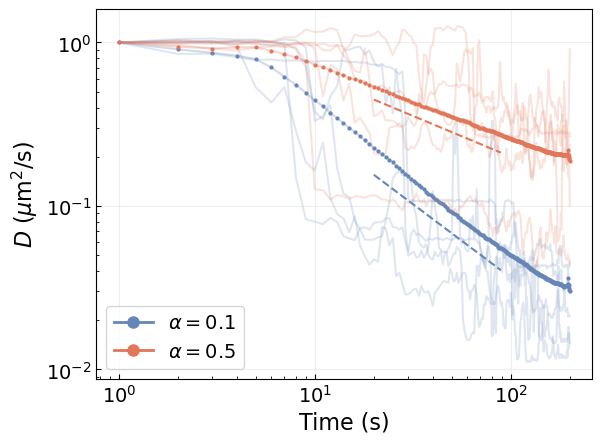

In [ ]:
x = np.arange(preds.shape[1]) + 1

# ALPHA = 0.1
for t in preds[:5, :]:
    t = 10**t
    t = t/t[0]
    plt.loglog(x, t, c=colors[0], alpha=0.2)
    
plt.loglog(x, sbm01/sbm01[0], c=colors[0], label=r'$\alpha = 0.1$', marker='o', ms=2, lw=0)
plt.loglog(x, sbm01/sbm01[0], c=colors[0], alpha=0.3)
    
# ALPHA = 0.5
for t in preds[-5:, :]:
    t = 10**t
    t = t/t[0]
    plt.loglog(x, t, c=colors[1], alpha=0.2)

plt.loglog(x, sbm05/sbm05[0], c=colors[1], marker='o', ms=2, lw=0)
plt.loglog(x, sbm05/sbm05[0], c=colors[1], alpha=0.3)

# Analytical scaling
alpha = 0.1
init, end = 20, 90
plt.plot(np.arange(init, end), 2.3*np.arange(init, end)**(0.1 - 1), c=colors[0], ls='--')
plt.plot(np.arange(init, end), 2*np.arange(init, end)**(0.5 - 1), c=colors[1], ls='--')


plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("$D$ " + D_units, fontsize=16)

plt.grid(alpha=alpha_grid)
legend_elements = [Line2D([0], [0], color=colors[0], marker='o', lw=2, markersize=8, label=r'$\alpha = 0.1$'),
                   Line2D([0], [0], color=colors[1], marker='o', lw=2, markersize=8, label=r'$\alpha = 0.5$')]
plt.legend(handles=legend_elements, fontsize=14)

plt.tick_params(direction='in')
plt.tick_params(which='minor', direction='in')
plt.tick_params(labelsize=14)

# plt.savefig(FIG_PATH/'fig_sbm.pdf', transparent=True, bbox_inches='tight')

# ATTM over simulated trajectories and experiments

The annealed transit time model (ATTM) is characterized by trajectories that changes diffusive states at random according to a gamma distribution: $$P(D) = \frac{D^{\sigma - 1}\exp(-D/b)}{b^\sigma\Gamma(\sigma)}\,.$$ Then, the residence time in each diffusive state, $\tau$, depends on the magnitude of the diffusion coefficient: $$P_\tau(\tau|D)=\frac{D^\gamma}{k}\exp(-\tau D^\gamma/k)\,.$$

The parameters $\sigma$ and $\gamma$ in these distributions determine the anomalous exponent $\alpha=\sigma/\gamma$.

## Introduction to ATTM

We start by providing an intuiditve depiction of ATTM trajectories and their properties. For this purpose, we use both the theoretical expressions to illustrate the distributions, as well as simulated trajectories to show the weak ergodicity breaking phenomenon.

### Trajectory example

Let's start with a schematic example just to illustrate the phenomenon that ATTM trajectories change diffusion coefficient over time.

In [ ]:
from step.data import brownian_motion 

In [ ]:
np.random.seed(2)
segment_lengths = [20, 7, 15]
diffusion_coefficients = [1e-2, 1e0, 1e-1]
length = np.sum(segment_lengths)
example_d = np.repeat(diffusion_coefficients, segment_lengths)
example_traj = brownian_motion(1, length, example_d, dim=2).squeeze()

### $P(D)$ and $P(\tau|D)$

It is also nice to visualize the probability density functions for the diffusion coefficient and their duration. However, rather than plotting $P(\tau|D)$ for all $D$, we will plot he expected value of $\tau$ which goes as $\sim kD^{-\gamma}$.

In [ ]:
from scipy.special import gamma as gamma_fun

In [ ]:
def p_d_log(D_log, sigma, b): return np.log(10)*(10**D_log)*(10**D_log)**(sigma - 1)*np.exp(-(10**D_log)/b)/(gamma_fun(sigma)*b**sigma)
def p_tau_mean(D, k, gamma): return k*D**(-gamma)

### MSD scaling

Finally, to illustrate the weak ergodicity breaking, we use some simulated trajectories to compute the time-averaged mean square dispacement (TA-MSD) and the ensemble-averaged MSD (EA-MSD). In ergodic processes, both quantities have the same value.

The EA-MSD scales as a power-law with time $\sim t^\alpha$, thus resulting in anomalous diffusion.

In [ ]:
from step.data import create_fixed_attm_trajs

In [ ]:
sigmas = sigmas = [0.2, 0.3, 0.4]
gamma = 0.5

In [ ]:
len_sim = 1000
t_lags = np.arange(2, len_sim)
ea_msds = []
np.random.seed(7)
# for s in sigmas:
#     trajs, ds = create_fixed_attm_trajs(20000, len_sim, s, gamma)
#     ea_msds.append(np.sum(trajs**2, axis=1).mean(0)[1:])

In [ ]:
# def sq_displacements(trajs, t_lag):
#     return np.sum((trajs[:, :, t_lag:] - trajs[:, :, :-t_lag])**2, axis=1)

# def ta_msd(trajs, t_lag=2):
#     return sq_displacements(trajs, t_lag).mean(-1)

# def ea_msd(trajs, t_lag=2):
#     return sq_displacements(trajs, t_lag).mean(0)

# def tea_msd(trajs, max_t=None, t_lag=2):
#     return ea_msd(trajs[:, :, :max_t], t_lag).mean(-1)

In [ ]:
# t_lags = np.arange(1, 150)
# ta_msds, ea_msds = [], []
# for t_lag in t_lags:
#     ta_msds.append(ta_msd(trajectories, t_lag).mean(0))
#     ea_msds.append(ea_msd(trajectories, t_lag)[0])

### Plot the introduction (a)

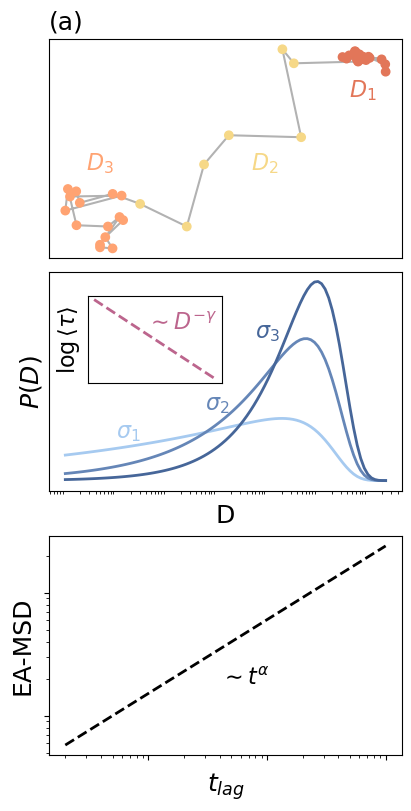

In [ ]:
fig = plt.figure(figsize=(fig_size, 2*fig_size), constrained_layout=True)
fontsize = 18
ticksize = 16

gs = fig.add_gridspec(nrows=3, ncols=1)

# EXAMPLE TRAJECTORY
colors_segments = [colors[1], colors_light[2], colors_light[1]]
ax_traj = fig.add_subplot(gs[0, :])
point_colors = np.concatenate([[c]*l for c, l in zip(colors_segments, segment_lengths)])
ax_traj.plot(example_traj[0, :], example_traj[1, :], color='k', alpha=0.3, zorder=-1)
ax_traj.scatter(example_traj[0, :], example_traj[1, :], color=point_colors)
ax_traj.set_xticks([])
ax_traj.set_yticks([])
ax_traj.text(-0.7, -0.8, r'$D_1$', fontsize=ticksize, color=colors_segments[0])
ax_traj.text(-2.6, -3.2, r'$D_2$', fontsize=ticksize, color=colors_segments[1])
ax_traj.text(-5.8, -3.2, r'$D_3$', fontsize=ticksize, color=colors_segments[2]) 

ax_traj.annotate('(a)', (0, 1.05), xycoords='axes fraction', fontsize=fontsize)

# THEORETICAL CURVES
meshgrid_d = np.linspace(-8, -1, 100)
sigmas = [0.1, 0.3, 0.5]
ax_pd = fig.add_subplot(gs[1, 0])
shades_blue = [colors_light[0], colors[0], colors_dark[0]]
for i, s in enumerate(sigmas):
    mask = meshgrid_d < -1.6
    ax_pd.semilogx(10**meshgrid_d[mask], p_d_log(meshgrid_d[mask], s, 0.002), linewidth=linewidth, color=shades_blue[i])
# log_ticks = [base*10**power for power in np.arange(-8, 0).astype(float) for base in np.arange(1, 10)]
# ax_pd.set_xticks(log_ticks)
ax_pd.text(1e-7, 0.12, r'$\sigma_1$', fontsize=ticksize, color=shades_blue[0])
ax_pd.text(6e-6, 0.2, r'$\sigma_2$', fontsize=ticksize, color=shades_blue[1])
ax_pd.text(6e-5, 0.4, r'$\sigma_3$', fontsize=ticksize, color=shades_blue[2])
ax_pd.set_yticks([])
ax_pd.set_xticks([])
ax_pd.set_xlabel(r"D", fontsize=fontsize)
ax_pd.set_ylabel(r"$P(D)$", fontsize=fontsize)

# ax_tau = fig.add_subplot(gs[1, 1])
ax_tau = ax_pd.inset_axes([0.11, 0.49, 0.38, 0.4]) # x, y, w, h
ax_tau.loglog(10**meshgrid_d, p_tau_mean(10**meshgrid_d, 0.4, 1.), '--', linewidth=linewidth, color=colors[3])
# ax_tau.text(1e-8, 1e5, r'$\sim D^{-\gamma}$', fontsize=ticksize, color=colors[3])
ax_tau.text(1e-5, 1e5, r'$\sim D^{-\gamma}$', fontsize=ticksize, color=colors[3])
ax_tau.set_xticks([])
ax_tau.set_yticks([])
# ax_tau.set_xlabel(r"$\log D$", fontsize=fontsize)
ax_tau.set_ylabel(r"$\log \left\langle \tau\right\rangle$", fontsize=ticksize)

# MSD
ax_msd = fig.add_subplot(gs[2, :])
for i, msd in enumerate(ea_msds):
    ax_msd.loglog(t_lags, msd, linewidth=linewidth, color=shades_blue[i])
ax_msd.loglog(t_lags, 0.38*t_lags**(sigmas[1]/gamma), '--', linewidth=linewidth, color='k')

# for i, s in enumerate(sigmas):
#     ax_msd.loglog(t_lags, t_lags**(s/gamma), linewidth=linewidth, color=colors[i])
ax_msd.text(40, 1.8, r'$\sim t^\alpha$', fontsize=ticksize)
# ax_msd.loglog(t_lags, ta_msds, linewidth=linewidth, color=colors[0], label='TA-MSD')
# ax_msd.loglog(t_lags, ea_msds, linewidth=linewidth, color=colors[1], label='EA-MSD')
# ax_msd.legend(fontsize=ticksize)
# ax_msd.text(7, 0.7, r'$\sim t^\alpha$', fontsize=ticksize, color=colors[1])
ax_msd.set_xticklabels([])
ax_msd.set_yticklabels([])
ax_msd.set_xlabel(r"$t_{lag}$", fontsize=fontsize)
ax_msd.set_ylabel(r"EA-MSD", fontsize=fontsize);


plt.savefig(FIG_PATH/'attm_left.pdf', transparent=True, bbox_inches='tight');

## Process the simulated trajectories

We start to load the results over simulated trajectories. We take a representative example in order to show the overall procedure.

In [ ]:
DATA_EXP = DATA_PATH/'data_carlo/data_prx/'
sigma, gamma = 0.30, 0.40
df_attm = pd.read_csv(DATA_EXP/f'preds_attm_{sigma:.2f}s_{gamma:.2f}g.csv')

In [ ]:
df_attm['D_tfm'] = np.where(df_attm.pred_D_100x > 2, df_attm.pred_D_10x - 2, df_attm.pred_D_100x - 4)

### Diffusion coefficient distribution by segments 

In [ ]:
def find_segments(pred_d, traj, pen=1, **kwargs):
    import ruptures as rpt
    alg = rpt.KernelCPD(**kwargs).fit(pred_d) # Only changes in D
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    seg_Ds = []
            
    Ds = np.ones_like(pred_d)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        D = pred_d[i:j].mean()
        Ds[i:j] *= D
        seg_Ds.append(D)

    res_time = cps[1:] - cps[:-1]
    res_time = res_time[1:-1]
    Ds_clean = seg_Ds[1:-1]
    
    return Ds, seg_Ds, Ds_clean, res_time

In [ ]:
seg_ds_pred, seg_ds_clean = [], []
seg_res = []

for idx in tqdm(np.unique(df_attm.traj_idx)):
    mask = df_attm.traj_idx == idx
    pred_d = df_attm.loc[mask, 'D_tfm'].values
    x, y = df_attm[mask].x.values, df_attm[mask].y.values
    traj = np.array([x-x[0], y-y[0]])

    out_sim = find_segments(pred_d, traj, min_size=5, pen=0.51)
    Ds, d_seg_sim, d_seg_sim_clean, res_time_sim = out_sim
    
    df_attm.loc[mask, 'D_segment'] = Ds
    seg_ds_pred.append(d_seg_sim)
    seg_ds_clean.append(d_seg_sim_clean)
    seg_res.append(res_time_sim)
    # seg_ds_true.append(d_seg_true)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
seg_ds_pred = np.concatenate(seg_ds_pred)
seg_ds_clean = np.concatenate(seg_ds_clean)
seg_res = np.concatenate(seg_res)

In [ ]:
bins = np.linspace(-7, 0, 21)
counts_pred_sim, edges_sim = np.histogram(seg_ds_pred, bins=bins, density=True)

### Fitting $\sigma$ 

In [ ]:
sigma_true = [0.300, 0.300, 0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.800, 0.350, 0.750, 0.850, 0.900, 0.950, 1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30]
gamma_true = [0.400, 0.900, 0.500, 0.500, 1.00, 0.750, 1.40, 1.05, 1.25, 1.70, 1.20, 1.65, 1.30, 0.950, 1.40, 1.60, 1.90, 1.30, 1.30, 2.10, 1.70, 1.75]
sigma_pred = [0.260, 0.301, 0.355, 0.398, 0.490, 0.545, 0.531, 0.622, 0.704, 0.768, 0.342, 0.727, 0.822, 0.924, 1.13, 0.903, 0.975, 1.11, 1.06, 1.02, 1.30, 1.31]

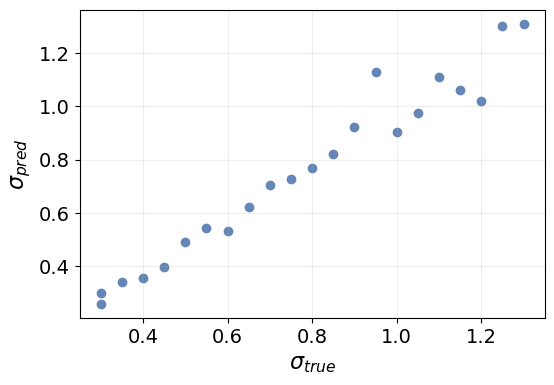

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(sigma_true, sigma_pred, color=colors[0])
plt.grid(alpha=alpha_grid)
plt.xlabel(r'$\sigma_{true}$', fontsize=16)
plt.ylabel(r'$\sigma_{pred}$', fontsize=16)
plt.tick_params(labelsize=14);

### Residence times 

In [ ]:
bins_d_tau = np.linspace(-6.5, -1, 56)
bins_tau = np.logspace(1.3, 2.3, 51)
hist, edges_d_sim, edges_tau = np.histogram2d(seg_ds_clean, seg_res, bins=(bins_d_tau, bins_tau))

In [ ]:
from scipy.optimize import curve_fit
def tau_mean(D, gamma, k): return k*D**(-gamma)

In [ ]:
D_values, dD = np.arange(-6., -2.2, 0.05), 0.2
intervals = [(D - dD, D + dD) for D in D_values]
means = []

for D, interval in zip(D_values, intervals):
    low, high = interval
    mask = (seg_ds_clean >= low) & (seg_ds_clean < high) & (seg_res > 10)
    means.append(seg_res[mask].mean())
means = np.array(means)

In [ ]:
mask_fit = (D_values > -5.5) & (D_values < -3.9)
params_means, _ = curve_fit(tau_mean, 10**D_values[mask_fit], means[mask_fit])
print(f"gamma = {params_means[0]:.3f}\nk = {params_means[1]:.3f}")

gamma = 0.359
k = 1.553


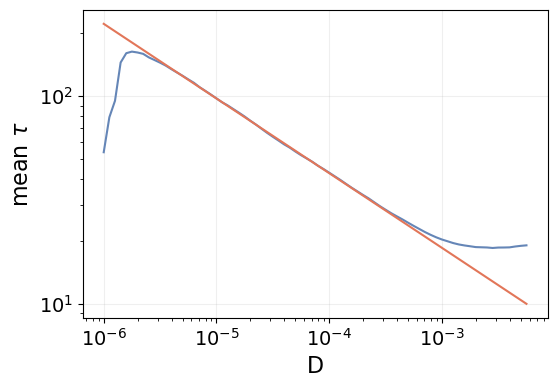

In [ ]:
plt.figure(figsize=(6, 4))
plt.loglog(10**D_values, means, color=colors[0])
plt.loglog(10**D_values, tau_mean(10**D_values, *params_means), color=colors[1])
plt.grid(alpha=alpha_grid)
plt.tick_params(labelsize=14)
plt.xlabel("D", fontsize=16)
plt.ylabel(r"mean $\tau$", fontsize=16);

### Plot the simulation results (b), (c) and (d)

Text(0, 1.05, '(d)')

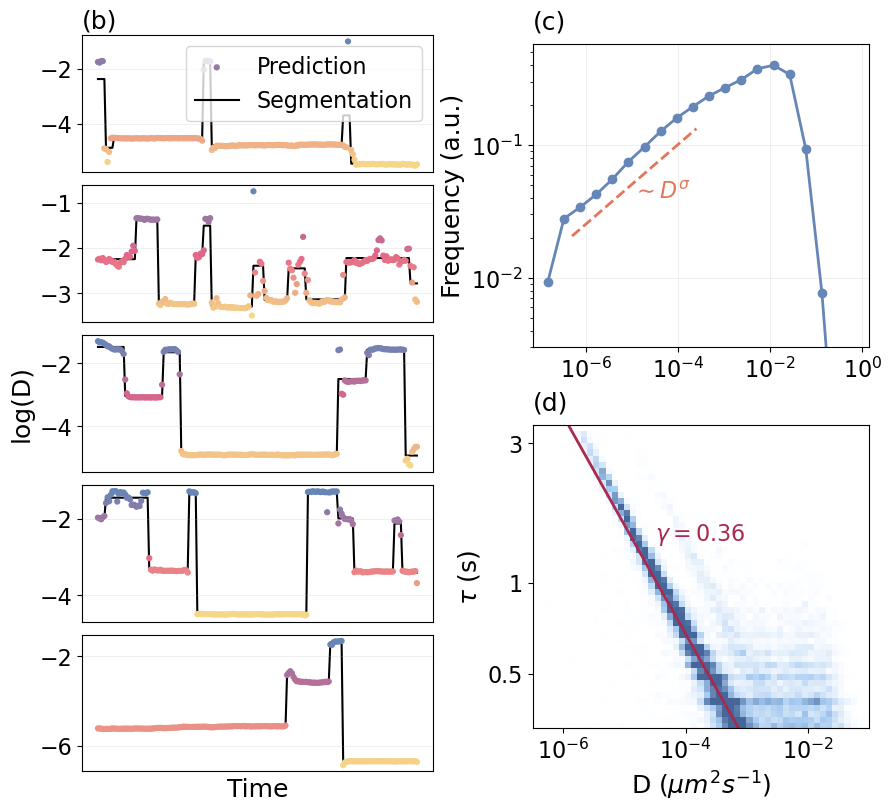

In [ ]:
fig = plt.figure(figsize=(2.2*fig_size, 2*fig_size), constrained_layout=True)
fontsize = 18
ticksize = 16

gs = fig.add_gridspec(ncols=2, width_ratios=[0.49, 0.51])
gs_left = gs[0, 0].subgridspec(5, 1, wspace=0)
gs_right = gs[0, 1].subgridspec(2, 1)

# Prediction examples
example_idx = [1695, 2550, 6700, 2612, 7472]
for i, idx in enumerate(example_idx):
    mask = df_attm.traj_idx == idx
    x, y = df_attm.x[mask].values, df_attm.y[mask].values
    d_pred = df_attm.D_tfm[mask].values
    d_segment = df_attm[mask].D_segment.values
    
    ax_d = fig.add_subplot(gs_left[i, 0])
    ax_d.scatter(np.arange(len(d_pred)), d_pred, s=scatter_size, c=d_pred, cmap=cmap_points, label='Prediction')
    ax_d.plot(d_segment, color='k', label='Segmentation', zorder=-1)
    ax_d.grid(alpha=alpha_grid)
    ax_d.tick_params(labelsize=ticksize)
    
    if i == 0:
        ax_d.legend(fontsize=ticksize, loc='upper right')
        ax_d.annotate('(b)', (0, 1.05), xycoords='axes fraction', fontsize=fontsize)
    if i == len(example_idx)//2:
        ax_d.set_ylabel("log(D)", fontsize=fontsize)
    if i == len(example_idx) - 1:
        ax_d.set_xlabel("Time", fontsize=fontsize)
        ax_d.set_yticks([-2, -6])
        
    ax_d.set_xticks([])
    ax_d.set_xticklabels([])
    # ax_d.set_yticks([])
    # ax_d.set_yticklabels([])
        
# POWER-LAW FIT OF THE P(D) DISTRIBUTION
x_sim = edges_sim[:-1] + np.diff(edges_sim)/2
x_ref = np.logspace(-6.3, -3.6, 41)
ax_pd = fig.add_subplot(gs_right[0, 0])

ax_pd.semilogx(10**x_sim, counts_pred_sim, 'o-', linewidth=linewidth, label='Prediction', color=colors[0])
ax_pd.semilogx(x_ref, 1.6*x_ref**sigma, '--', linewidth=linewidth, label='Theory', color=colors[1])
ax_pd.text(1e-5, 4e-2, r'$\sim D^{\sigma}$', fontsize=ticksize, color=colors[1])
ax_pd.set_yscale('log')
ax_pd.set_ylim(ymin=3e-3)
# ax_pd.legend(fontsize=ticksize, loc='lower right')
ax_pd.grid(alpha=alpha_grid)
ax_pd.set_ylabel("Frequency (a.u.)", fontsize=fontsize)
ax_pd.tick_params(labelsize=ticksize)

ax_pd.annotate('(c)', (0, 1.05), xycoords='axes fraction', fontsize=fontsize)


# POWER-LAW FIT OF P(tau|D)
ax_tau = fig.add_subplot(gs_right[1, 0])

tau_fit_x = bins_d_tau[:-1] + np.diff(bins_d_tau)/2
tau_fit_y = tau_mean(10**tau_fit_x, *params_means)
dy = np.log10(edges_tau[1]/edges_tau[0])
tau_fit_y = np.log10(tau_fit_y/edges_tau[0])/dy # Convert to pixels to put on top of the histogram

ax_tau.pcolor(hist.T/hist.max(), cmap=cmap_hist1, rasterized=True, vmax=0.4)
ax_tau.plot(tau_fit_y, linewidth=linewidth, color=colors_dark[3])
ax_tau.text(20, 31, r'$\gamma=0.36$', fontsize=ticksize, color=colors_dark[3])
ax_tau.set_ylim([0, hist.shape[1]])
ax_tau.set_xlabel(r"D ($\mu m^2 s^{-1}$)", fontsize=fontsize)
ax_tau.set_xticks(np.arange(hist.shape[0])[5::20], [fr'$10^{{{e:.0f}}}$' for e in edges_d_sim[5::20]])
ax_tau.set_ylabel(r"$\tau$ (s)", fontsize=fontsize)
idx_tau = np.array([9, 24, -3])
ax_tau.set_yticks(np.arange(hist.shape[1])[idx_tau], 
                  [f'{e/60:.1f}' if int(10*e/60)%10 else f'{e/60:.0f}' for e in edges_tau[idx_tau]]) # convert to seconds @ 60Hz
ax_tau.tick_params(labelsize=ticksize)

ax_tau.annotate('(d)', (0, 1.05), xycoords='axes fraction', fontsize=fontsize)

# plt.savefig(FIG_PATH/'attm_middle.pdf', transparent=True, bbox_inches='tight');

## Process the experimental trajectories

We apply the same procedure to study experimental trajectories of the pathogen-recognition receptor DC-SIGN. These trajectories were originally used to demonstrate anomalous diffusion and weak ergodicity breaking as a result of changes in the diffusion coefficient along time in [this work](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.5.011021). The data is in $\mu m^2$/frame sampled at 60Hz

In [ ]:
DATA_EXP = DATA_PATH/'data_carlo/data_prx/'
df_web = pd.read_csv(DATA_EXP/'preds_prx.csv')
df_web = df_web.rename(columns={'index': 'traj_idx'})

Just like before, we need to adjust the range of our predictions.

In [ ]:
correction = -4
df_web['D_tfm'] = df_web.pred_D_100x + correction

We now proceed to segment the resulting predictions.

In [ ]:
def find_segments(pred_d, pred_alpha, traj, pen=1, **kwargs):
    import ruptures as rpt
    pred = np.stack((pred_d , pred_alpha), axis=-1)
    alg = rpt.KernelCPD(**kwargs).fit(pred_d) # Only changes in D
    # alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    seg_Ds, seg_alphas = [], []
            
    Ds = np.ones_like(pred_d)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        alpha, D = pred_alpha[i:j].mean(), pred_d[i:j].mean()
        Ds[i:j] *= D

        seg_alphas.append(alpha)
        seg_Ds.append(D)

    res_time = cps[1:] - cps[:-1]
    res_time = res_time[1:-1]
    alphas_clean, Ds_clean = seg_alphas[1:-1], seg_Ds[1:-1]
    n_cp = len(cps)-1
    
    return Ds, seg_Ds, seg_alphas, Ds_clean, alphas_clean, res_time, n_cp

In [ ]:
preds, alphas = [], []
seg_ds, seg_alphas, n_cps = [], [], []
seg_ds_clean, seg_alphas_clean, seg_res, seg_vars = [], [], [], []

for idx in tqdm(np.unique(df_web.traj_idx)):
    mask = df_web.traj_idx == idx
    pred_d = df_web.loc[mask, 'D_tfm'].values
    pred_alpha = df_web.loc[mask, 'pred_alpha'].values
    x, y = df_web[mask].x.values, df_web[mask].y.values
    traj = np.array([x-x[0], y-y[0]])

    out = find_segments(pred_d, pred_alpha, traj, min_size=10, pen=0.51)
    Ds, d_seg, a_seg, ds_clean, as_clean, res_time, n_cp = out
    
    df_web.loc[mask, 'D_segment'] = Ds
    seg_ds.append(d_seg)
    seg_alphas.append(a_seg)
    seg_res.append(res_time)
    seg_ds_clean.append(ds_clean)
    seg_alphas_clean.append(as_clean)
    n_cps.append(n_cp)
    preds.append(pred_d)
    alphas.append(pred_alpha)

  0%|          | 0/755 [00:00<?, ?it/s]

In [ ]:
seg_alphas, seg_ds = np.concatenate(seg_alphas), np.concatenate(seg_ds)
seg_alphas_clean = np.concatenate(seg_alphas_clean)
seg_ds_clean = np.concatenate(seg_ds_clean)
seg_res = np.concatenate(seg_res)

### D distribution

First, we proceed to empirically estimate the probability distribution from the predictions to obtain $\sigma$. The experimental data is in $\mu m^2$/frame and it was sampled at 60Hz. We will need to apply a correction factor to the resulting diffusion coefficient to obtain the corresponding physical units.

In [ ]:
correction = np.log10(60)
data_d = seg_ds + correction # seg_ds or seg_ds_clean
counts, edges = np.histogram(data_d, bins=np.linspace(-6, 1, 41), density=True)

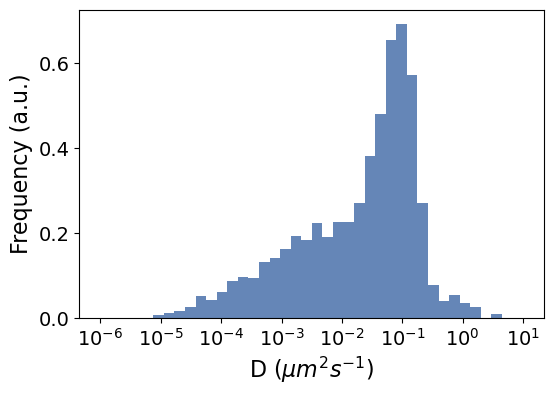

In [ ]:
bin_size = edges[1] - edges[0]
x_hist = edges[:-1] + bin_size/2
plt.figure(figsize=(6, 4))
plt.bar(x_hist, counts, width=bin_size, color=colors[0])
plt.xticks(np.arange(-6, 2), [fr'$10^{{{t}}}$' for t in np.arange(-6, 2)])
plt.xlabel(r"D $(\mu m^2 s^{-1})$", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16)
plt.tick_params(labelsize=14);

Let's fit a line in the power-law regime to find $\sigma$. We know that $P(D)\propto D^{\sigma - 1}$ and, therefore, $P(\log(D))\propto D^\sigma$. We need to pay close attention to this, as we have indeed obtained the density for $P(\log(D))$ meaning that the slope in the log-log regime is $\sigma$ and not $\sigma-1$. 

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
power_law_fit = lambda x, a, b: a*x + b
x_fit = edges[:-1] + np.diff(edges)/2
# mask_fit = (-4.5 < x_fit) & (x_fit < -1.2)
mask_fit = (-4.5 < x_fit) & (x_fit < -2.3)
params, _ = curve_fit(power_law_fit, x_fit[mask_fit], np.log10(counts[mask_fit]))

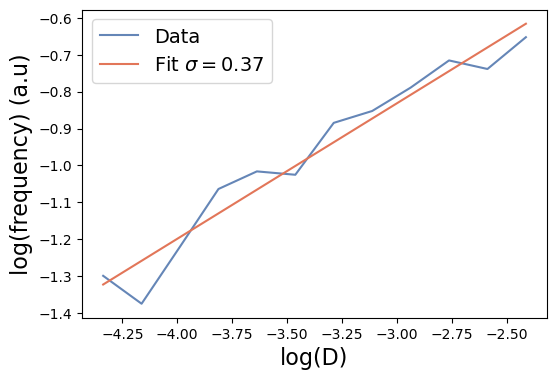

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(x_fit[mask_fit], np.log10(counts[mask_fit]), label="Data", color=colors[0])
plt.plot(x_fit[mask_fit], power_law_fit(x_fit[mask_fit], *params),
         label=fr"Fit $\sigma=${params[0]:.2f}", color=colors[1])
plt.legend(fontsize=14)
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("log(frequency) (a.u)", fontsize=16);

### $\alpha$ vs D distribution

In [ ]:
bins_d, bins_alpha = np.linspace(-6.2, 1.4, 39), np.arange(0, 2.1, 0.05)
hist_d_alpha, edges_d_exp, edges_alpha = np.histogram2d(data_d, seg_alphas, bins=[bins_d, bins_alpha])

### Plot the experimental results (e), (f), (g)

In [ ]:
import seaborn as sns

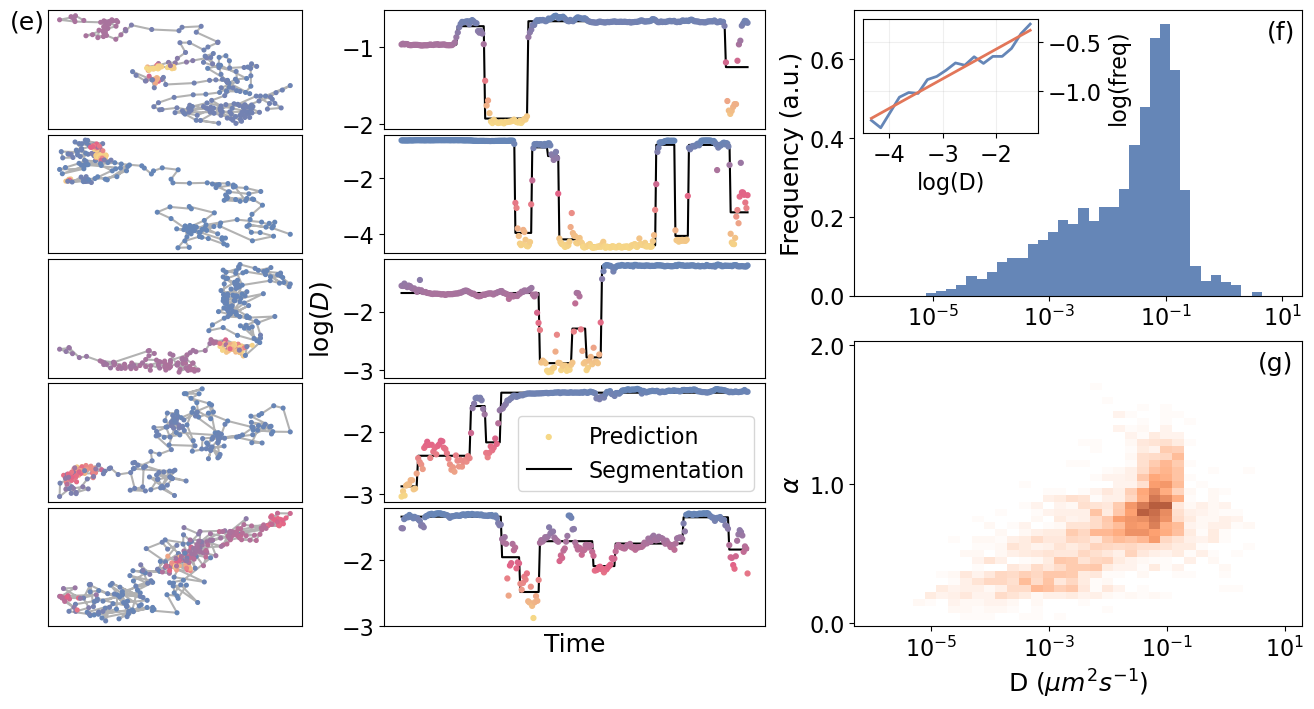

In [ ]:
fig = plt.figure(figsize=(3.2*fig_size, 2*fig_size))#, constrained_layout=True)
fontsize = 18
ticksize = 16

gs_examples = fig.add_gridspec(nrows=5, ncols=2, left=0.01, right=0.57, wspace=0.26, hspace=0.05, width_ratios=[0.4, 0.6])
gs_results = fig.add_gridspec(nrows=2, ncols=1, left=0.64, right=0.99, hspace=1.*ticksize/100)

# PREDICTION EXAMPLES
example_idx = [96, 97, 113, 9, 64] #[54, 56, 64, 91, 94]

for i, idx in enumerate(example_idx):
    mask = df_web.traj_idx == idx
    x, y = df_web.x[mask].values, df_web.y[mask].values
    pred = df_web.D_tfm[mask].values + correction
    seg = df_web.D_segment[mask].values + correction
    
    ax_traj = fig.add_subplot(gs_examples[i, 0])
    ax_traj.plot(x, y, alpha=0.3, color='k', zorder=-1)
    ax_traj.scatter(x, y, s=7, c=pred, cmap=cmap_points)
    ax_traj.set_xticks([])
    ax_traj.set_yticks([])
    
    if i == 0:
        ax_traj.annotate('(e)', (-0.15, 0.85), xycoords='axes fraction', fontsize=fontsize)
    
    ax_d = fig.add_subplot(gs_examples[i, 1])
    ax_d.scatter(np.arange(len(pred)), pred, s=scatter_size, c=pred, cmap=cmap_points, label='Prediction')
    ax_d.plot(seg, color='k', label='Segmentation', zorder=-1)
    ax_d.set_xticks([])
    # ax_d.set_yticks([])
    ax_d.tick_params(labelsize=ticksize)
    if i == len(example_idx) - 2:
        ax_d.legend(fontsize=ticksize, loc='lower right')
    if i == len(example_idx) - 1:
        ax_d.set_yticks([-2, -3])
        ax_d.set_xlabel("Time", fontsize=fontsize)
    if i == len(example_idx)//2:
        ax_d.set_ylabel(r"$\log(D)$", fontsize=fontsize)
    
# D DISTRIBUTION HISTOGRAM
ax_hist = fig.add_subplot(gs_results[0, 0])
ax_hist.bar(x_hist, counts, width=bin_size, color=colors[0])
x_ticks = np.arange(-5, 2, 2)
ax_hist.set_xticks(x_ticks, [fr'$10^{{{t}}}$' for t in x_ticks])
ax_hist.set_ylabel('Frequency (a.u.)', fontsize=fontsize)
ax_hist.tick_params(labelsize=ticksize)
ax_hist.annotate('(f)', (0.92, 0.9), xycoords='axes fraction', fontsize=fontsize)

ax_ins = ax_hist.inset_axes([0.02, 0.57, 0.39, 0.4]) # x, y, w, h
ax_ins.plot(x_fit[mask_fit], np.log10(counts[mask_fit]), linewidth=linewidth, color=colors[0])
ax_ins.plot(x_fit[mask_fit], power_law_fit(x_fit[mask_fit], *params), linewidth=linewidth, color=colors[1])
ax_ins.grid(alpha=alpha_grid)
ax_ins.set_xticks([-4, -3, -2])
ax_ins.yaxis.tick_right()
ax_ins.yaxis.set_label_position('right')
ax_ins.tick_params(labelsize=ticksize)
ax_ins.set_xlabel("log(D)", fontsize=ticksize)
ax_ins.set_ylabel("log(freq)", fontsize=ticksize)

# ALPHA VS D HISTOGRAM

ax_hist2 = fig.add_subplot(gs_results[1, 0])
ax_hist2.pcolor(hist_d_alpha.T/hist_d_alpha.max(), vmax=0.90, rasterized=True, cmap=cmap_hist2)
ax_hist2.set_xticks(np.arange(len(edges_d_exp))[6::10]+0.5, [fr'$10^{{{t:.0f}}}$' for t in edges_d_exp[6::10]])
ax_hist2.set_xlabel(r'D ($\mu m^2 s^{-1}$)', fontsize=fontsize)
ax_hist2.set_yticks(np.arange(len(edges_alpha))[::20]+0.5, [f'{t}' for t in edges_alpha[::20]])
ax_hist2.set_ylabel(r"$\alpha$", fontsize=fontsize)
ax_hist2.tick_params(labelsize=ticksize)
ax_hist2.annotate('(g)', (0.9, 0.9), xycoords='axes fraction', fontsize=fontsize);


# plt.savefig(FIG_PATH/'attm_right.pdf', transparent=True, bbox_inches='tight');

## Plot it all together

In [ ]:
import seaborn as sns

In [ ]:
def center_trajectory(x, y, fig_range):
    "Centers trajectory in a square plot."
    x_center = (x.max() + x.min())/2
    y_center = (y.max() + y.min())/2
    fig_center = (fig_range[1] + fig_range[0])/2
    return x + (fig_center - x_center), y + (fig_center - y_center)    

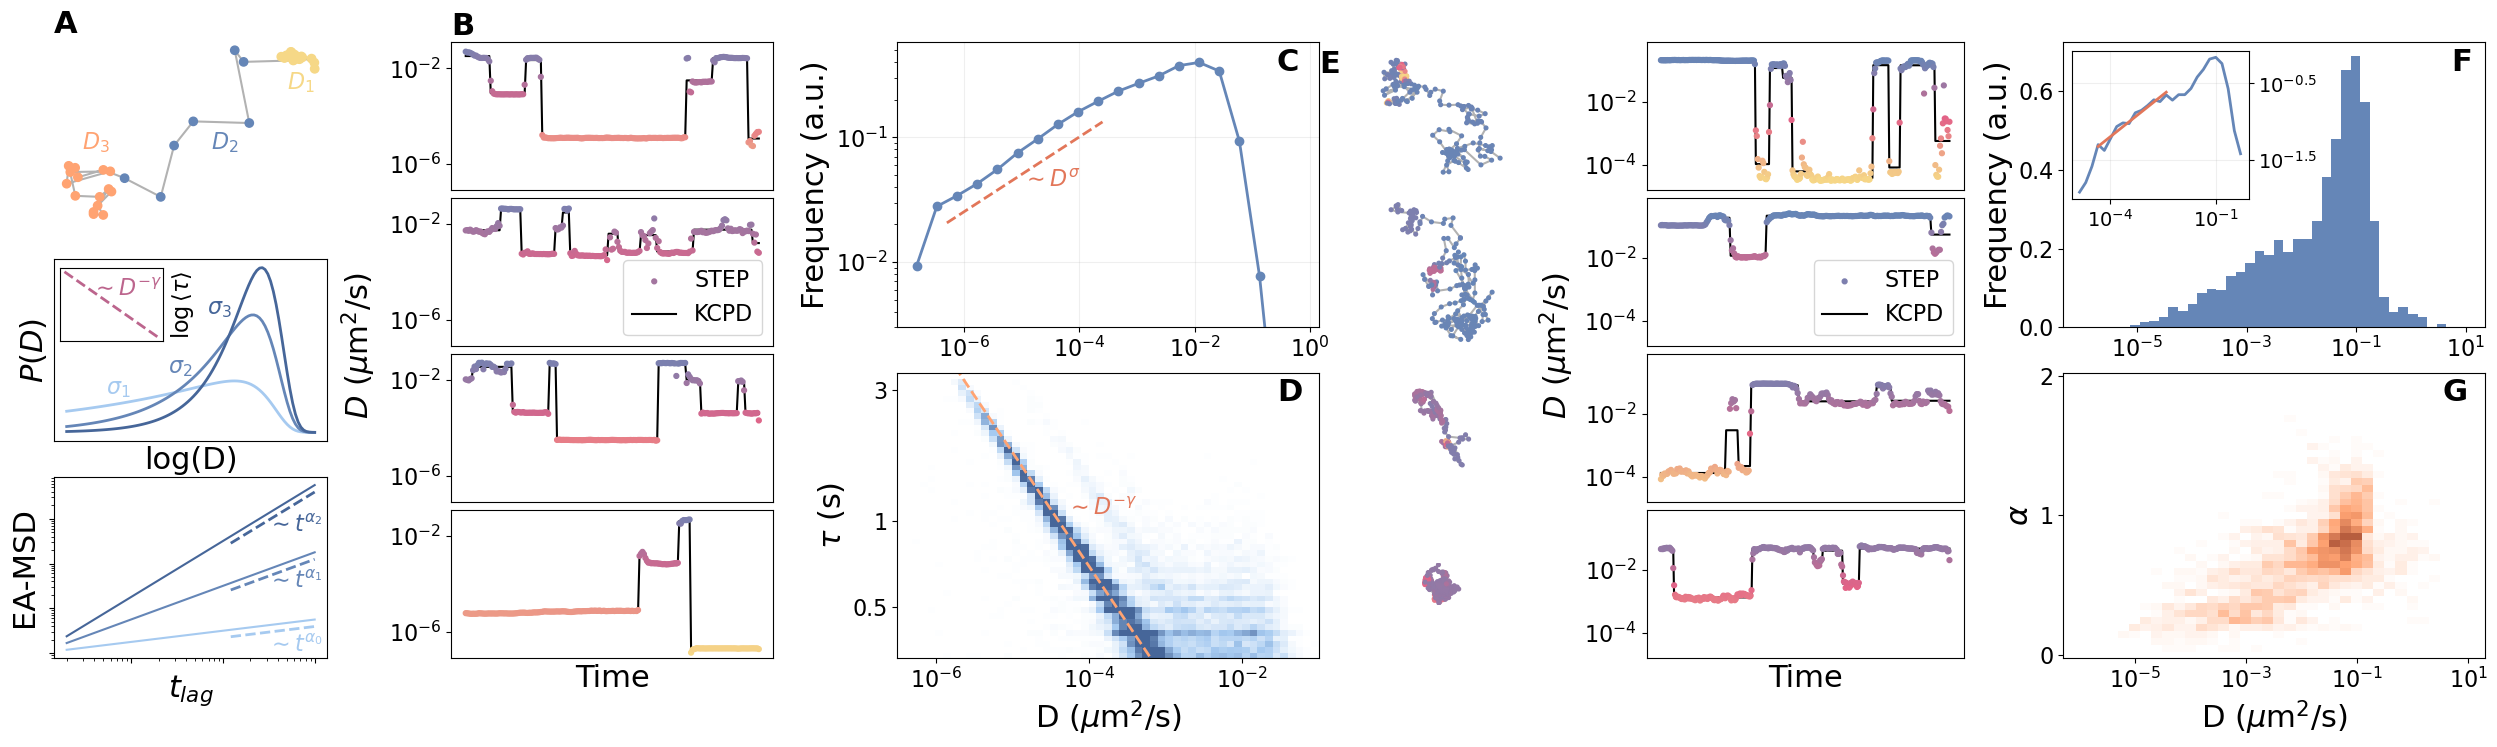

In [ ]:
fig = plt.figure(figsize=(6.2*fig_size, 2*fig_size))
fontsize = 22
ticksize = 16

gs_left = fig.add_gridspec(nrows=3, ncols=1, left=0.01, right=0.12)
gs_ex_sim = fig.add_gridspec(nrows=4, ncols=1, hspace=0.05, left=0.17, right=0.30)
gs_res_sim = fig.add_gridspec(nrows=2, ncols=1, left=0.35, right=0.52, hspace=ticksize/100)                            
gs_examples = fig.add_gridspec(nrows=4, ncols=2, left=0.52, right=0.78, wspace=0.3, hspace=0.05, width_ratios=[2.3, 3])
gs_results = fig.add_gridspec(nrows=2, ncols=1, left=0.82, right=0.99, hspace=ticksize/100)

### INTRODUCTION ###
# EXAMPLE TRAJECTORY
colors_segments = [colors_light[2], colors[0], colors_light[1]]
ax_traj = fig.add_subplot(gs_left[0, :])
point_colors = np.concatenate([[c]*l for c, l in zip(colors_segments, segment_lengths)])
ax_traj.plot(example_traj[0, :], example_traj[1, :], color='k', alpha=0.3, zorder=-1)
ax_traj.scatter(example_traj[0, :], example_traj[1, :], color=point_colors)
ax_traj.set_xticks([])
ax_traj.set_yticks([])
ax_traj.text(-0.7, -0.8, r'$D_1$', fontsize=ticksize, color=colors_segments[0])
ax_traj.text(-2.6, -3.2, r'$D_2$', fontsize=ticksize, color=colors_segments[1])
ax_traj.text(-5.8, -3.2, r'$D_3$', fontsize=ticksize, color=colors_segments[2])
ax_traj.set_axis_off()

ax_traj.annotate('A', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# THEORETICAL CURVES
meshgrid_d = np.linspace(-8, -1, 100)
sigmas = [0.1, 0.3, 0.5]
ax_pd = fig.add_subplot(gs_left[1, 0])
shades_blue = [colors_light[0], colors[0], colors_dark[0]]
for i, s in enumerate(sigmas):
    mask = meshgrid_d < -1.6
    ax_pd.semilogx(10**meshgrid_d[mask], p_d_log(meshgrid_d[mask], s, 0.002), linewidth=linewidth, color=shades_blue[i])
ax_pd.text(1e-7, 0.13, r'$\sigma_1$', fontsize=ticksize, color=shades_blue[0])
ax_pd.text(4e-6, 0.2, r'$\sigma_2$', fontsize=ticksize, color=shades_blue[1])
ax_pd.text(4e-5, 0.4, r'$\sigma_3$', fontsize=ticksize, color=shades_blue[2])
ax_pd.set_yticks([])
ax_pd.set_xticks([])
ax_pd.set_xlabel(r"log(D)", fontsize=fontsize)
ax_pd.set_ylabel(r"$P(D)$", fontsize=fontsize)

ax_tau = ax_pd.inset_axes([0.02, 0.55, 0.38, 0.4]) # x, y, w, h
ax_tau.loglog(10**meshgrid_d, p_tau_mean(10**meshgrid_d, 0.4, 1.), '--', linewidth=linewidth, color=colors[3])
# ax_tau.text(1e-8, 1e5, r'$\sim D^{-\gamma}$', fontsize=ticksize, color=colors[3])
ax_tau.text(1e-6, 1e5, r'$\sim D^{-\gamma}$', fontsize=ticksize, color=colors[3])
ax_tau.set_xticks([])
ax_tau.set_yticks([])
# ax_tau.set_xlabel(r"$\log D$", fontsize=fontsize)
ax_tau.set_ylabel(r"$\log \left\langle \tau\right\rangle$", fontsize=ticksize)
ax_tau.yaxis.set_label_position('right')

# MSD
ax_msd = fig.add_subplot(gs_left[2, :])
for i, s in enumerate(sigmas):
    power_law = t_lags**(s/gamma)
    ax_msd.loglog(t_lags, power_law, color=shades_blue[i])
    ax_msd.loglog(t_lags[120:], 0.7*power_law[120:], '--', linewidth=linewidth, color=shades_blue[i])
    ax_msd.text(300, (0.25 if i == 0 else 0.4)*power_law[300],  fr'$\sim t^{{\alpha_{{{i}}}}}$', 
                fontsize=ticksize, color=shades_blue[i])

ax_msd.set_xticklabels([])
ax_msd.set_yticklabels([])
ax_msd.set_xlabel(r"$t_{lag}$", fontsize=fontsize)
ax_msd.set_ylabel(r"EA-MSD", fontsize=fontsize)

### SIMULATED TRAJECTORIES ###
# Prediction examples
example_idx = [6700, 2550, 2612, 7472] # 1695
cmap_range = (min([np.min(df_attm.D_tfm[df_attm.traj_idx == idx]) for idx in example_idx]),
              max([np.max(df_attm.D_tfm[df_attm.traj_idx == idx]) for idx in example_idx]))
for i, idx in enumerate(example_idx):
    mask = df_attm.traj_idx == idx
    x, y = df_attm.x[mask].values, df_attm.y[mask].values
    d_pred = df_attm.D_tfm[mask].values
    d_segment = df_attm[mask].D_segment.values
    
    ax_d = fig.add_subplot(gs_ex_sim[i, 0])
    ax_d.scatter(np.arange(len(d_pred)), d_pred, s=scatter_size, c=d_pred, cmap=cmap_points,
                 vmin=cmap_range[0], vmax=cmap_range[1], label='STEP')
    ax_d.plot(d_segment, color='k', label='KCPD', zorder=-1)
    # ax_d.grid(alpha=alpha_grid)
    ax_d.tick_params(labelsize=ticksize)
    
    if i == 0:
        ax_d.annotate('B', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)
    if i == 1:
        ax_d.legend(fontsize=ticksize, loc='lower right')
    # if i == len(example_idx)//2:
        # ax_d.set_ylabel(r"$D$ " + D_units, fontsize=fontsize)
    if i == len(example_idx) - 1:
        ax_d.set_xlabel("Time", fontsize=fontsize)
        
    ax_d.set_ylim([-7.1, -0.9])
    ax_d.set_xticks([])
    ax_d.set_xticklabels([])
    ax_d.set_yticks([-2, -6], [fr"$10^{{{t}}}$" for t in [-2, -6]])
    
fig.text(0.125, 0.5, r"$D$ " + D_units, va='center', rotation='vertical', fontsize=fontsize)

        
# POWER-LAW FIT OF THE P(D) DISTRIBUTION
x_sim = edges_sim[:-1] + np.diff(edges_sim)/2
x_ref = np.logspace(-6.3, -3.6, 41)
ax_pd = fig.add_subplot(gs_res_sim[0, 0])

ax_pd.semilogx(10**x_sim, counts_pred_sim, 'o-', linewidth=linewidth, label='STEP', color=colors[0])
ax_pd.semilogx(x_ref, 1.6*x_ref**sigma, '--', linewidth=linewidth, label='Theory', color=colors[1])
ax_pd.text(1e-5, 4e-2, r'$\sim D^{\sigma}$', fontsize=ticksize, color=colors[1])
ax_pd.set_yscale('log')
ax_pd.set_ylim(ymin=3e-3)
ax_pd.grid(alpha=alpha_grid)
# ax_pd.set_xlabel(r"D ($\mu m^2 s^{-1}$)", fontsize=fontsize)
ax_pd.set_ylabel("Frequency (a.u.)", fontsize=fontsize)
ax_pd.tick_params(labelsize=ticksize)

ax_pd.annotate('C', (0.9, 0.9), xycoords='axes fraction', weight='bold', fontsize=fontsize)


# POWER-LAW FIT OF P(tau|D)
ax_tau = fig.add_subplot(gs_res_sim[1, 0])

tau_fit_x = bins_d_tau[:-1] + np.diff(bins_d_tau)/2
# tau_fit_y = tau_mean(10**tau_fit_x, *params_means)
tau_fit_y = tau_mean(10**tau_fit_x, gamma, 1.1)
dy = np.log10(edges_tau[1]/edges_tau[0])
tau_fit_y = np.log10(tau_fit_y/edges_tau[0])/dy # Convert to pixels to put on top of the histogram

ax_tau.pcolor(hist.T/hist.max(), cmap=cmap_hist1, rasterized=True, vmax=0.4)
ax_tau.plot(tau_fit_y, '--', linewidth=linewidth, color=colors_light[1])
# ax_tau.text(20, 31, r'$\gamma=0.36$', fontsize=ticksize, color=colors[1])
ax_tau.text(22, 25, r'$\sim D^{-\gamma}$', fontsize=ticksize, color=colors[1])
ax_tau.set_ylim([0, hist.shape[1]])
ax_tau.set_xlabel(r"D " + D_units, fontsize=fontsize)
ax_tau.set_xticks(np.arange(hist.shape[0])[5::20], [fr'$10^{{{e:.0f}}}$' for e in edges_d_sim[5::20]])
ax_tau.set_ylabel(r"$\tau$ (s)", fontsize=fontsize)
idx_tau = np.array([9, 24, -3])
ax_tau.set_yticks(np.arange(hist.shape[1])[idx_tau], 
                  [f'{e/60:.1f}' if int(10*e/60)%10 else f'{e/60:.0f}' for e in edges_tau[idx_tau]]) # convert to seconds @ 60Hz
ax_tau.tick_params(labelsize=ticksize)

ax_tau.annotate('D', (0.9, 0.9), xycoords='axes fraction', weight='bold', fontsize=fontsize)

### EXPERIMENTAL TRAJECTORIES ###
# PREDICTION EXAMPLES
example_idx = [97, 96, 347, 317] # 64, 113, 9, [54, 56, 91, 94] 347, 349, 244, 307, 317
cmap_range = (min([np.min(df_web.D_tfm[df_web.traj_idx == idx]) + correction for idx in example_idx]),
              max([np.max(df_web.D_tfm[df_web.traj_idx == idx]) + correction for idx in example_idx]))
example_range = (np.min([df_web.loc[df_web.traj_idx == idx, ['x', 'y']].min() for idx in example_idx]),
                 np.max([df_web.loc[df_web.traj_idx == idx, ['x', 'y']].max() for idx in example_idx]))
for i, idx in enumerate(example_idx):
    mask = df_web.traj_idx == idx
    x, y = df_web.x[mask].values, df_web.y[mask].values
    pred = df_web.D_tfm[mask].values + correction
    seg = df_web.D_segment[mask].values + correction
    
    x, y = center_trajectory(x, y, example_range)
    ax_traj = fig.add_subplot(gs_examples[i, 0])
    ax_traj.plot(x, y, alpha=0.3, color='k', zorder=-1)
    ax_traj.scatter(x, y, s=7, c=pred, cmap=cmap_points, vmin=cmap_range[0], vmax=cmap_range[1])
    ax_traj.set_xticks([])
    ax_traj.set_yticks([])
    ax_traj.set_xlim(*[1.05*l for l in example_range])
    ax_traj.set_aspect('equal')
    ax_traj.set_axis_off()
    
    if i == 0:
        ax_traj.annotate('E', (0., 0.85), xycoords='axes fraction', weight='bold', fontsize=fontsize)
    
    ax_d = fig.add_subplot(gs_examples[i, 1])
    ax_d.scatter(np.arange(len(pred)), pred, s=scatter_size, c=pred, cmap=cmap_points,
                 vmin=cmap_range[0], vmax=cmap_range[1], label='STEP')
    ax_d.plot(seg, color='k', label='KCPD', zorder=-1)
    ax_d.set_ylim([-4.8, -0.1])
    ax_d.set_xticks([])
    ax_d.set_yticks([-2, -4], [fr"$10^{{{t}}}$" for t in [-2, -4]])
    ax_d.tick_params(labelsize=ticksize)
    if i == 1:
        ax_d.legend(fontsize=ticksize, loc='lower right')
    # if i == len(example_idx)//2:
        # ax_d.set_ylabel(r"$D$ " + D_units, fontsize=fontsize)
    if i == len(example_idx) - 1:
        ax_d.set_xlabel("Time", fontsize=fontsize)
        
fig.text(0.608, 0.5, r"$D$ " + D_units, va='center', rotation='vertical', fontsize=fontsize)
    
# D DISTRIBUTION HISTOGRAM
ax_hist = fig.add_subplot(gs_results[0, 0])
ax_hist.bar(x_hist, counts, width=bin_size, color=colors[0])
x_ticks = np.arange(-5, 2, 2)
ax_hist.set_xticks(x_ticks, [fr'$10^{{{t}}}$' for t in x_ticks])
ax_hist.set_ylabel('Frequency (a.u.)', fontsize=fontsize)
ax_hist.tick_params(labelsize=ticksize)
ax_hist.annotate('F', (0.92, 0.9), xycoords='axes fraction', weight='bold', fontsize=fontsize)

ax_ins = ax_hist.inset_axes([0.02, 0.45, 0.42, 0.52]) # x, y, w, h
# ax_ins.plot(x_fit[mask_fit], np.log10(counts[mask_fit]), 'o-', linewidth=linewidth, color=colors[0])
mask_log_plot = (x_hist > -5.) & (x_hist < -0.2)
ax_ins.plot(x_hist[mask_log_plot], np.log10(counts[mask_log_plot]), linewidth=linewidth, color=colors[0])
ax_ins.plot(x_fit[mask_fit], power_law_fit(x_fit[mask_fit], *params),
            linewidth=linewidth, color=colors[1])
ax_ins.grid(alpha=alpha_grid)
# ax_ins.set_xticks([-4, -2], [r'$10^{-4}$', r'$10^{-2}$'])
# ax_ins.set_yticks([-0.5, -1], [r'$10^{-0.5}$', r'$10^{-1}$'])
ax_ins.set_xticks([-4, -1], [r'$10^{-4}$', r'$10^{-1}$'])
ax_ins.set_yticks([-0.5, -1.5], [r'$10^{-0.5}$', r'$10^{-1.5}$'])
ax_ins.yaxis.tick_right()
ax_ins.yaxis.set_label_position('right')
ax_ins.tick_params(labelsize=ticksize-2)

# ALPHA VS D HISTOGRAM

ax_hist2 = fig.add_subplot(gs_results[1, 0])
ax_hist2.pcolor(hist_d_alpha.T/hist_d_alpha.max(), vmax=0.90, rasterized=True, cmap=cmap_hist2)
ax_hist2.set_xticks(np.arange(len(edges_d_exp))[6::10]+0.5, [fr'$10^{{{t:.0f}}}$' for t in edges_d_exp[6::10]])
ax_hist2.set_xlabel(r'D ' + D_units, fontsize=fontsize)
ax_hist2.set_yticks(np.arange(len(edges_alpha))[::20]+0.5, [f'{t:.0f}' for t in edges_alpha[::20]])
ax_hist2.set_ylabel(r"$\alpha$", fontsize=fontsize)
ax_hist2.tick_params(labelsize=ticksize)
ax_hist2.annotate('G', (0.9, 0.9), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# plt.savefig(FIG_PATH/"attm.pdf", bbox_inches='tight', transparent=True)

# Multi-state diffusion processes

We study the motion of the integring $\alpha_5\beta_1$ in the membrane of HeLa cells. These integrins have been reported to switch from fast-free diffusion to slow-free diffusion and immobilization. Additionally, they can exhibit rearward actin-driven motion. Thus, this results in four different diffusive states in which we can find the integrins.

The trajectories are in pixel and frame units, with every pixel corresponding to 109.67nm acquired at 33Hz.

## Load the trajectories

Let's first load the data and show a few trajectory examples with their predictions.

In [ ]:
data_path = Path('../../../hdd/seg_data/data_carlo')
df_wt = pd.read_csv(data_path/'inference_WT_noise.csv', header=None)
df_wt = df_wt.rename(columns={0: 'x', 1: 'y', 12: 'traj_idx', 13: 'D', 14: 'D_100x', 15: 'alpha'})

In [ ]:
len(df_wt.traj_idx.unique())

4734

In [ ]:
lengths = [(df_wt.traj_idx == idx).sum() for idx in df_wt.traj_idx.unique()]

In [ ]:
min(lengths), max(lengths)

(20, 500)

Since the diffusion coefficient predictions did not fit in the output range of our model, we need to combine the original outputs with the predictions in the rescaled trajectories. We take the rescaled prediction on $D$ wherever the original prediction was lower than $-2$, and we correct it by a factor of $-4$.

In [ ]:
threshold, correction = -2, -4
df_wt['D_tfm'] = np.where(df_wt.D >= threshold, df_wt.D, df_wt.D_100x + correction)

## Segmentation

Now we proceed to find the different segments in the trajectory. We use $D$ and $\alpha$ to find the change points, and we fit a constant segment to the data points between them. Additionally, we compute the angle between consecutive steps for a posterior analysis. 

In [ ]:
def find_segments(pred_d, pred_alpha, traj, pen=1, **kwargs):
    import ruptures as rpt
    pred = np.stack((pred_d , pred_alpha), axis=-1)
#     alg = rpt.KernelCPD(**kwargs).fit(pred_d) # Only changes in D
    alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, alphas, angles = [], [], [], []
            
    seg_labels = np.ones_like(pred_d)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        alpha_seg, D_seg = pred_alpha[i:j].mean(), pred_d[i:j].mean()
        seg_labels[i:j] *= D_seg
        
        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            segments.append(segment)
        alphas.append(alpha_seg)
        Ds.append(D_seg)

    return seg_labels, segments, Ds, alphas, angles

import math
 
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

In [ ]:
Ds, preds, trajs, alphas = [], [], [], []
seg_ds, seg_alphas, seg_angs = [], [], []

for idx in tqdm(np.unique(df_wt.traj_idx)):
    mask = df_wt.traj_idx == idx
    pred_d = df_wt.loc[mask, 'D_tfm'].values
    pred_alpha = df_wt.loc[mask, 'alpha'].values
    x, y = df_wt[mask].x.values, df_wt[mask].y.values
    traj = np.array([x-x[0], y-y[0]])

    out = find_segments(pred_d, pred_alpha, traj, min_size=5, pen=0.1, kernel="rbf")
    new_labels, segments, d_seg, a_seg, angs = out
    
    df_wt.loc[mask, 'D_segment'] = new_labels
    seg_ds.append(d_seg)
    seg_alphas.append(a_seg)
    seg_angs.append(angs)
    preds.append(pred_d)
    Ds.append(np.power(10, pred_d))
    alphas.append(pred_alpha)
    trajs.append(segments)

  0%|          | 0/4734 [00:00<?, ?it/s]

In [ ]:
seg_alphas, seg_ds = np.concatenate(seg_alphas), np.concatenate(seg_ds)

## Clustering

Now we can run a clustering algorithm over our segments. As we have shown in the [in-depth analysis of these trajectories](), the most likely number of clusters is four.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

First of all, we normalize the data.

In [ ]:
scaler = StandardScaler()
x = np.stack(((seg_ds + 7)/4, seg_alphas), axis=-1)
x = scaler.fit_transform(x)

And now we run the k-means algorithm on top of it.

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=10, max_iter=300, random_state=42)
kmeans.fit(x)
seg_labels = kmeans.predict(x)

## Angle distribution by clusters

With the clusters, we can look at the angle distribution for each population.

In [ ]:
angle_0, angle_1, angle_2, angle_3 = [], [], [], []
angs = [a for ang in seg_angs for a in ang]

for l, a  in zip(seg_labels, angs):
    if l == 0:   angle_0.append(a)
    elif l == 1: angle_1.append(a)
    elif l == 2: angle_2.append(a)
    elif l == 3: angle_3.append(a)

In [ ]:
angle_0, angle_1 = np.concatenate(angle_0), np.concatenate(angle_1)
angle_2, angle_3 = np.concatenate(angle_2), np.concatenate(angle_3)

## Radius of confinement

Finally, we can obtain compute the confinement radius of the different populations. To obtain the confinement radius, we need to compute the covariance matrix of the segment. Then, we diagonalize it and compute the square root of the mean of its eigenvalues.

In [ ]:
segments = [s for seg in trajs for s in seg]
radi = np.zeros_like(seg_labels, dtype=float)

for i, seg in enumerate(segments):
    cov = np.cov(seg)
    e_vals, _ = np.linalg.eigh(cov)
    radi[i] = np.sqrt(e_vals.mean())

In [ ]:
pixel_size = 109.67 # nanometers/pixel
radi *= 2*pixel_size

Now that we have the confinement radius of all the segments, we can compute the distribution for each population.

In [ ]:
from scipy.stats import sem

In [ ]:
segment_lengths = np.array([s.shape[1] for s in segments])

In [ ]:
radius_distribution_cluster = []
radius_mean_cluster, radius_sem_cluster = [], []
radius_median_cluster, radius_std_cluster = [], []
bins = [np.linspace(0, 500, 51), np.linspace(0, 650, 51), np.linspace(0, 100, 51), np.linspace(0, 600, 51)]
for c, b in zip(range(4), bins):
    mask = seg_labels == c
    radius_mean_cluster.append(np.average(radi[mask], weights=segment_lengths[mask]))
    radius_sem_cluster.append(sem(radi[mask]))
    radius_median_cluster.append(np.median(radi[mask]))
    radius_std_cluster.append(np.std(radi[mask]))
    radius_distribution_cluster.append(np.histogram(radi[mask], bins=b, density=True))

In [ ]:
radius_median_cluster

[90.4166653210962, 202.39849023178283, 14.876618090536942, 162.76211496893538]

In [ ]:
radius_std_cluster

[98.2235410075843, 113.3364458759321, 13.330314129214374, 95.79048323335509]

## Plot it all together

In [ ]:
import seaborn as sns

def center_trajectory(x, y, fig_range):
    "Centers trajectory in a square plot."
    x_center = (x.max() + x.min())/2
    y_center = (y.max() + y.min())/2
    fig_center = (fig_range[1] + fig_range[0])/2
    return x + (fig_center - x_center), y + (fig_center - y_center)

In [ ]:
correction_D = np.log10(33*0.10967**2)

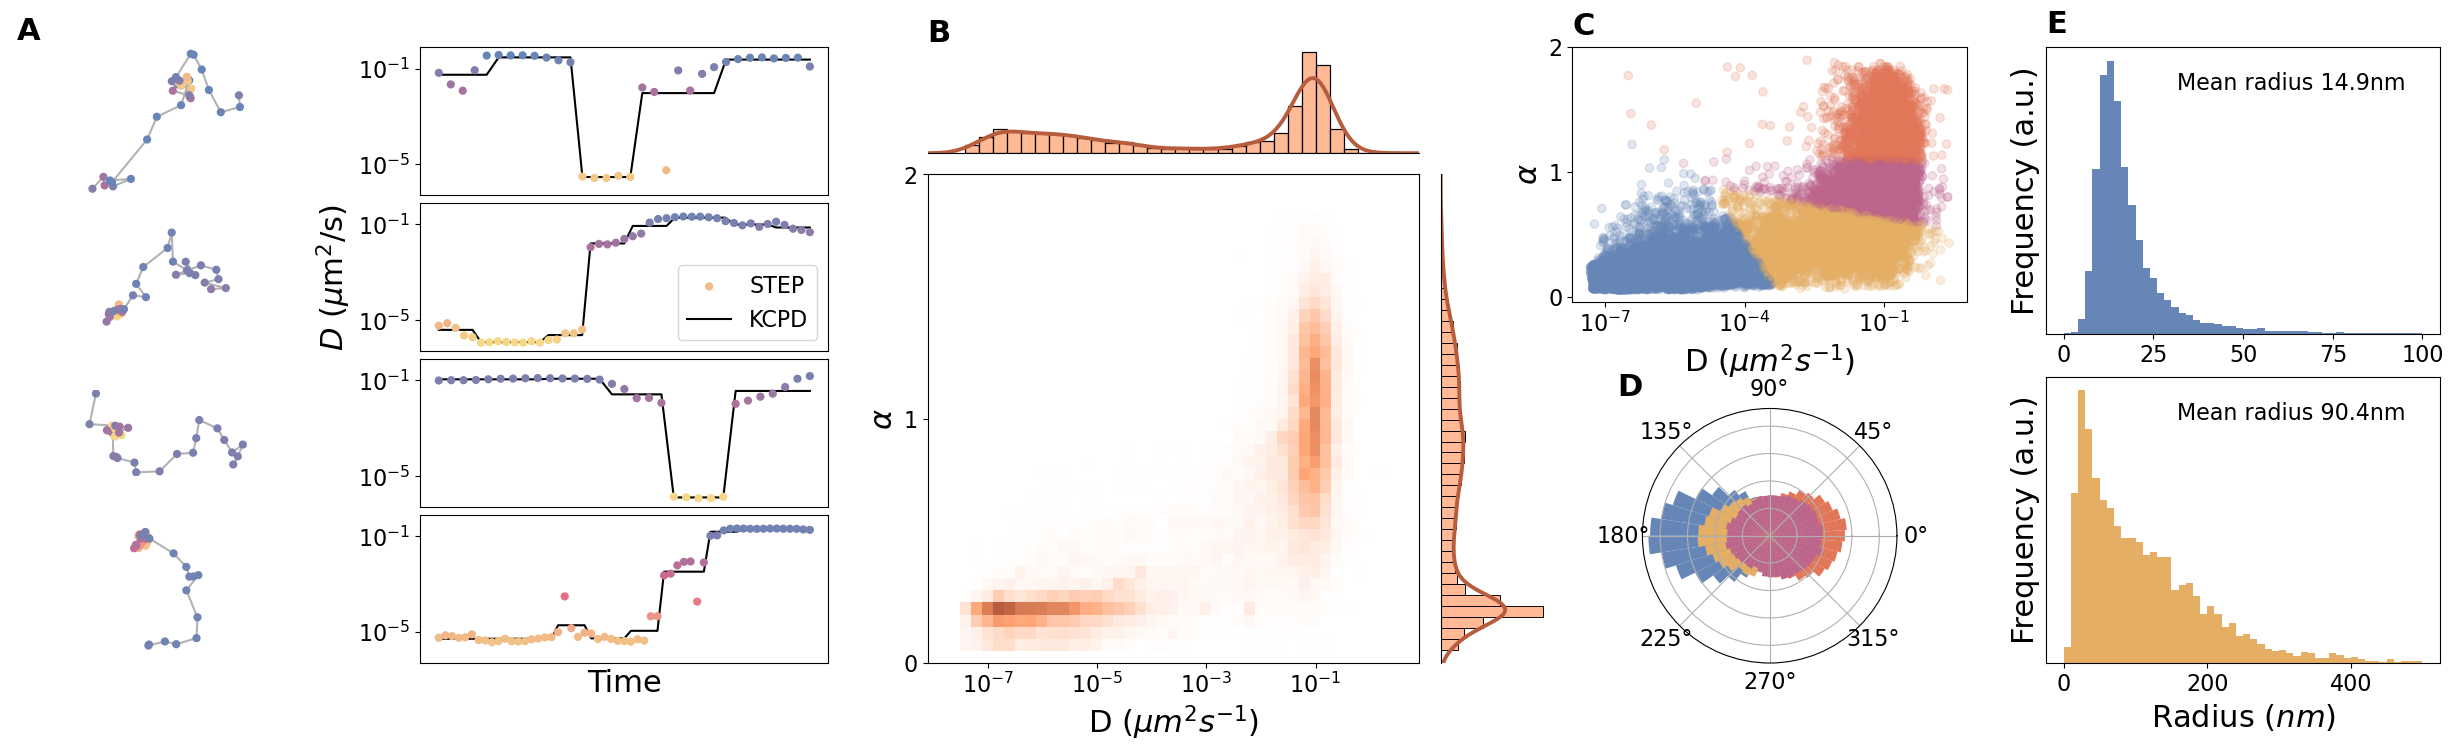

In [ ]:
fig = plt.figure(figsize=(6.2*fig_size, 2*fig_size))
fontsize = 22
ticksize = 16

gs_left = fig.add_gridspec(nrows=4, ncols=2, width_ratios=[2.3, 3], left=0.01, right=0.34, wspace=0.27, hspace=0.05)
gs_mid = fig.add_gridspec(nrows=5, ncols=5, left=0.38, right=0.63)
gs_right = fig.add_gridspec(nrows=1, ncols=2, left=0.64, right=0.99)

### TRAJECTORY AND PREDICTION EXAMPLES ###
example_idx = [174, 71, 86, 215]#, 157] # [1, 18, 71, 73, 86, 135, 157, 174, 215, 229]
cmap_range = (min([np.min(df_wt.D_tfm[df_wt.traj_idx == idx]) for idx in example_idx]),
              max([np.max(df_wt.D_tfm[df_wt.traj_idx == idx]) for idx in example_idx]))
example_range = [0, 0]
for idx in example_idx:
    mask = df_wt.traj_idx == idx
    traj = df_wt.loc[mask, ['x', 'y']].values - df_wt.loc[mask, ['x', 'y']].values[0]
    example_range[0] = min(example_range[0], traj.min())
    example_range[1] = max(example_range[1], traj.max())
    
for i, idx in enumerate(example_idx):
    mask = df_wt.traj_idx == idx
    x, y = df_wt.x[mask].values, df_wt.y[mask].values
    pred = df_wt.D_tfm[mask].values
    seg = df_wt.D_segment[mask].values
    
    x, y = center_trajectory(x - x[0], y - y[0], example_range)
    ax_traj = fig.add_subplot(gs_left[i, 0])
    ax_traj.scatter(x, y, s=2*scatter_size, c=pred, cmap=cmap_points,
                    vmin=cmap_range[0], vmax=cmap_range[1])
    ax_traj.plot(x, y, alpha=0.3, color='k', zorder=-1)
    ax_traj.set_xticks([])
    ax_traj.set_yticks([])
    ax_traj.set_xlim(*[1.05*l for l in example_range])
    ax_traj.set_aspect('equal')
    ax_traj.set_axis_off()
     
    if i == 0:
        ax_traj.annotate('A', (0., 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

    ax_d = fig.add_subplot(gs_left[i, 1])
    ax_d.scatter(np.arange(len(pred)), pred, s=2*scatter_size, c=pred, cmap=cmap_points,
                 vmin=cmap_range[0], vmax=cmap_range[1], label='STEP')
    ax_d.plot(seg, color='k', label='KCPD', zorder=-1)
    ax_d.set_xticks([])
    ax_d.set_ylim([-6.3, -0.1])
    ax_d.set_yticks([-1, -5], [fr"$10^{{{t}}}$" for t in [-1, -5]])
    ax_d.tick_params(labelsize=ticksize)
    if i == 1:
        ax_d.set_ylabel(r"$D$ " + D_units, fontsize=fontsize)
        ax_d.legend(fontsize=ticksize, loc='lower right')
    if i == len(example_idx) - 1:
        ax_d.set_xlabel("Time", fontsize=fontsize)
        
### ALPHA VS D HISTOGRAM ###
bins_d, bins_alpha = np.linspace(-8, 1, 46), np.arange(0, 2.05, 0.05)
hist_alpha_d, edges_d, edges_alpha = np.histogram2d(seg_ds + correction_D, seg_alphas, bins=[bins_d, bins_alpha], density=True)

# JOINT DISTRIBUTION
ax_joint = fig.add_subplot(gs_mid[1:, :-1])
ax_joint.pcolor(hist_alpha_d.T/hist_alpha_d.max(), cmap=cmap_hist2, rasterized=True)
ax_joint.set_xlabel(r"D $(\mu m^2 s^{-1})$", fontsize=fontsize)
ax_joint.set_ylabel(r"$\alpha$", fontsize=fontsize)
ax_joint.set_xticks(np.arange(len(edges_d))[5:-1:10]+0.5,
                    [fr'$10^{{{t:.0f}}}$' for t in edges_d[5:-1:10]])
ax_joint.set_yticks(np.arange(len(edges_alpha))[::len(edges_alpha)//2],
                    [f"{t:.0f}" for t in edges_alpha[::len(edges_alpha)//2]])
ax_joint.tick_params(labelsize=ticksize)

# MARGINAL D
ax_d = fig.add_subplot(gs_mid[0, :-1])
sns.kdeplot(seg_ds + correction_D, ax=ax_d, linewidth=1.4*linewidth, color=colors_dark[1])
sns.histplot(seg_ds + correction_D, ax=ax_d, stat='density', color=colors_light[1])
ax_d.set_xticks([])
ax_d.set_ylabel('')
ax_d.set_yticks([])
ax_d.set_xlim([edges_d.min(), edges_d.max()])
ax_d.spines['top'].set_visible(False)
ax_d.spines['left'].set_visible(False)
ax_d.spines['right'].set_visible(False)
ax_d.annotate('B', (0, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# MARGINAL ALPHA
ax_a = fig.add_subplot(gs_mid[1:, -1])
sns.kdeplot(y=seg_alphas, ax=ax_a, linewidth=1.4*linewidth, color=colors_dark[1])
sns.histplot(y=seg_alphas, ax=ax_a, stat='density', color=colors_light[1])
ax_a.set_xticks([])
ax_a.set_xlabel('')
ax_a.set_yticks([])
ax_a.set_ylim([edges_alpha.min(), edges_alpha.max()])
ax_a.spines['top'].set_visible(False)
ax_a.spines['bottom'].set_visible(False)
ax_a.spines['right'].set_visible(False)

### CLUSTERS ###
gs_0 = gs_right[0, 0].subgridspec(nrows=2, ncols=1, hspace=0.42)
gs_1 = gs_right[0, 1].subgridspec(nrows=2, ncols=1, hspace=0.15)
map_clusters = {0: 2, 1: 1, 2: 0, 3: 3}
cluster_colors = np.array([map_clusters[c] for c in seg_labels])

# SCATTER PLOT WITH LABELS
ax_labels = fig.add_subplot(gs_0[0])
ax_labels.scatter(seg_ds + correction_D, seg_alphas, c=cluster_colors, alpha=0.2, rasterized=True,
                  cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4))

xticks = [-7, -4, -1]
ax_labels.set_xticks(xticks, [fr'$10^{{{t:.0f}}}$' for t in xticks])
ax_labels.set_yticks(np.arange(0, 2.1, 1.))
ax_labels.set_xlabel(r'D $(\mu m^2 s^{-1})$', fontsize=fontsize)
ax_labels.set_ylabel(r'$\alpha$', fontsize=fontsize)
ax_labels.tick_params(labelsize=ticksize)
ax_labels.annotate('C', (0., 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# ANGLE DISTRIBUTION
ax_angle = fig.add_subplot(gs_0[1], projection='polar')
for i, ang in enumerate([angle_2, angle_1, angle_0, angle_3]):
    ax_angle.hist(2*np.pi*np.array(ang)/360, bins=41, density=True, color=colors[i])

    ax_angle.tick_params(labelsize=ticksize)
    ax_angle.set_yticklabels([])
ax_angle.annotate('D', (-0.1, 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)
    
# RADIUS OF CONFINEMENT
slow_populations = [2, 0]
for i, c in enumerate(slow_populations):
    counts, edges = radius_distribution_cluster[c]
    
    ax_radius = fig.add_subplot(gs_1[i])
    ax_radius.bar(edges[:-1] + np.diff(edges)/2, counts,
                  width=edges[1]-edges[0], color=colors[map_clusters[c]])
    ax_radius.tick_params(labelsize=ticksize)
    if i == 0:
        ax_radius.annotate('E', (0., 1.05), xycoords='axes fraction', weight='bold', fontsize=fontsize)
    if i == 1: 
        ax_radius.set_xlabel("Radius $(nm)$", fontsize=fontsize)
    ax_radius.set_yticks([])
    ax_radius.set_ylabel("Frequency (a.u.)", fontsize=fontsize)
    
    text_pos = (ax_radius.get_xlim()[-1]*0.3, ax_radius.get_ylim()[-1]*0.85)
    ax_radius.text(*text_pos, fr'Mean radius {radius_median_cluster[c]:.1f}nm', fontsize=ticksize)
    
# plt.savefig(FIG_PATH/"integrin.pdf", bbox_inches='tight', transparent=True)

In [ ]:
cluster_D, cluster_alpha, cluster_pct = [], [], []
total_length = segment_lengths.sum()
for c in np.unique(seg_labels):
    mask = seg_labels == c
    cluster_pct.append(segment_lengths[mask].sum()/total_length)
    cluster_D.append(np.average(10**(seg_ds[mask] + correction_D), weights=segment_lengths[mask]))
    cluster_alpha.append(np.average(seg_alphas[mask], weights=segment_lengths[mask]))

In [ ]:
for c in np.unique(seg_labels):
    print(fr"Cluster {c} ({100*cluster_pct[c]:.0f}%): D={cluster_D[c]:.2e} alpha={cluster_alpha[c]:.2f}")

Cluster 0 (14%): D=5.86e-02 alpha=0.46
Cluster 1 (20%): D=1.40e-01 alpha=1.30
Cluster 2 (40%): D=1.25e-05 alpha=0.23
Cluster 3 (26%): D=1.18e-01 alpha=0.87


# Appendix - Complementary analysis on diffusion coefficient
## Relative error as function of the number of segments
In this case, we load a dataframe with the metrics by segment lengths. 

In [ ]:
ds_cp_path = DATA_PATH/"constant_segment_analysis.pkl"
ds_cp = pd.read_pickle(ds_cp_path)

We filter the dataset to keep only the segment lengths of interest. In order to avoid cluttering the plots, we have taken length intervals of 20. 

In [ ]:
segment_lengths = np.array([20, 40, 60])
mask_lengths = sum([ds_cp.seg_len == l for l in segment_lengths]).astype(bool)
ds_cp = ds_cp[mask_lengths]

Finally, we compute the value of the metric and its error of the mean as a function of the number of change points, which is equivalent to the number of segments minus one. In this case, we care about the relative error by segment `'seg_rel_error'`.

In [ ]:
def get_metric_sem_per_cp(metric, ds):
    "Returns the metric per change point from dataset ds."
    segment_lengths = ds.seg_len.unique().astype(int)
    n_cps = ds.n_cp.unique().astype(int)
    metric_per_cp = np.zeros((len(segment_lengths), len(n_cps)))
    err_per_cp = np.zeros_like(metric_per_cp)                         
    for k, length in enumerate(segment_lengths):
        metric_per_cp[k, :] = np.array([getattr(ds, metric)[(ds.seg_len == length) & (ds.n_cp == n_cp)].mean()
                                 for n_cp in n_cps])
        err_per_cp[k, :] = np.array([getattr(ds, metric)[(ds.seg_len == length) & (ds.n_cp == n_cp)].sem() 
                               for n_cp in n_cps])
    return metric_per_cp, err_per_cp

In [ ]:
metric = 'seg_rel_error'
rel_err_per_cp, rel_err_sem_per_cp = get_metric_sem_per_cp(metric, ds_cp)

In [ ]:
n_seg_rel_error = ds_cp.n_cp.unique().astype(int) + 1

## Relative error as function of relative noise
In this case, we load the data containing the relative error as function of the noise.

In [ ]:
fig_name = FIG_PATH/"noise_analysis.pkl"
with open(fig_name, 'rb') as f:
    noise_err, noise_err_std, x, counts = pickle.load(f)

We also compute the statistical error of the mean for the plot.

In [ ]:
sem_noise = noise_err_std/counts.sqrt().unsqueeze(-1)

To make the plotting easier, we transpose the tensors and remove the data we will not consider. In this case, we remove the data corresponding to the post-processing of the predictions.

In [ ]:
mask = np.array([True, True, False, True])
noise_err, sem_noise = noise_err.T[mask], sem_noise.T[mask]

## Accuracy as function of the number of segments

To avoid cluttering the plot, we filter the data by lengths.

In [ ]:
# Filter the dataframe by lengths
segment_lengths = np.array([20, 40, 60])
mask_lengths = sum([ds_cp.seg_len == l for l in segment_lengths]).astype(bool)
ds_cp = ds_cp[mask_lengths]

We also need to remove those trajectories without any change point.

In [ ]:
ds_cp = ds_cp[ds_cp.n_cp != 0].reset_index(drop=True)

And now we can retrieve the metric per number of change points using the function that we defined before. In this case, the key is `'detect_rate'`.

In [ ]:
from step.baselines import ruptures_cp
from step.utils import jaccard_index, evaluate_cp_prediction

In [ ]:
j_idx_parameters = {'tp': [], 'fp': [], 'fn': []}
for _, (pred, cp) in ds_cp[['pred', 'cp']].iterrows():
    metrics = evaluate_cp_prediction(cp, ruptures_cp(pred.numpy(), pen=2.))
    for k, v in metrics.items():
        if k in j_idx_parameters.keys():
            j_idx_parameters[k].append(v)

for k, v in j_idx_parameters.items():
    ds_cp[k] = v

In [ ]:
j_idx_per_cp = np.zeros_like(rel_err_per_cp)[:, :-1]
for i, length in enumerate(ds_cp.seg_len.unique()):
    for j, n_cp in enumerate(ds_cp.n_cp.unique().astype(int)):
        mask = (ds_cp.seg_len == length) & (ds_cp.n_cp == n_cp)
        j_idx_per_cp[i, j] = jaccard_index(ds_cp.tp[mask].sum(), ds_cp.fp[mask].sum(), ds_cp.fn[mask].sum())

## Plot

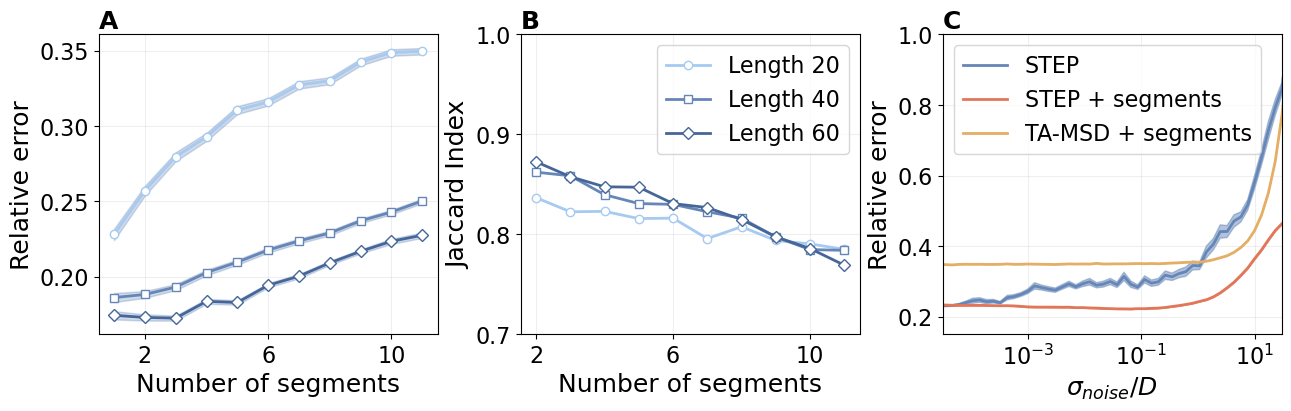

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(3.2*fig_size, fig_size), constrained_layout=True)
fontsize = 18
ticksize = 16

labels = ['STEP', 'STEP + segments', 'TA-MSD + segments']
markers = ['o', 's', 'D']
shades_blue = [colors_light[0], colors[0], colors_dark[0]]

# REL ERROR VS NUMBER OF SEGMENTS
for k, (val, err, length) in enumerate(zip(rel_err_per_cp, rel_err_sem_per_cp, segment_lengths)):
    ax[0].plot(n_seg_rel_error, val, marker = markers[k], label=f"length {length}", c=shades_blue[k],
               markerfacecolor='w', lw=linewidth)
    ax[0].fill_between(n_seg_rel_error, val - err, val + err, alpha=0.3, color=colors[0])
ax[0].set_xticks([2, 6, 10])
ax[0].set_xlabel("Number of segments", fontsize=fontsize)
ax[0].set_ylabel("Relative error", fontsize=fontsize)
ax[0].grid(alpha=alpha_grid)
ax[0].tick_params(labelsize=ticksize)

# JI VS NUMBER OF SEGMENTS
n_seg = ds_cp.n_cp.unique().astype(int) + 1
for k, (val, length) in enumerate(zip(j_idx_per_cp, segment_lengths)):
    ax[1].plot(n_seg, val, marker = markers[k], label=f"Length {length}", c=shades_blue[k],
               markerfacecolor='w', lw=linewidth)
    # ax[1].fill_between(n_seg, val - err, val + err, alpha=0.3, color=colors[0])
xticks = [2, 6, 10]
ax[1].set_xticks(xticks)
ax[1].set_ylim([0.7, 1.])
ax[1].grid(alpha=alpha_grid)
ax[1].legend(fontsize=ticksize)
ax[1].set_ylabel("Jaccard Index", fontsize=fontsize)
ax[1].set_xlabel("Number of segments", fontsize=fontsize)
ax[1].tick_params(labelsize=ticksize)

# NOISE
for k, (err, s) in enumerate(zip(noise_err, sem_noise)):
    ax[2].semilogx(10**x, err, '-', linewidth=2., c=colors[k], label=labels[k])
    ax[2].fill_between(10**x, err - s, err + s, alpha=0.5, color = colors[k])
ax[2].legend(fontsize=ticksize)
ax[2].grid(alpha = alpha_grid)
ax[2].set_xlim([10**(-4.5), 30])
ax[2].set_ylim([0.15, 1.])
ax[2].tick_params(labelsize=ticksize)
ax[2].set_xlabel(r"$\sigma_{noise}/D$", fontsize=fontsize)
ax[2].set_ylabel("Relative error", fontsize=fontsize)
ax[2].tick_params(labelsize=ticksize)

for a, let in zip(ax, 'ABC'):
    a.annotate(let, (0, 1.02), xycoords='axes fraction', weight='bold', fontsize=fontsize)

# plt.savefig(FIG_PATH/"appendix_complementary_d.pdf", bbox_inches='tight', transparent=True)

# Appendix - Anomalous exponent deep dive

In the main text, we briefly show how to use STEP to study anomalous diffusion processes. In this appendix, we provide further resutls to complement the analysis.

In [ ]:
# print(f"STEP: {metric_by_length['mae']['global']:.3f}")
# print(f"STEP + segments: {metric_by_length['mae_segment']['global']:.3f}")
# print(f"TA-MSD + segments: {metric_by_length['mae_tmsd']['global']:.3f}")

STEP: 0.271
STEP + segments: 0.275
TA-MSD + segments: 0.368


## CONDOR baseline

In [ ]:
condor_path = FIG_PATH/"CONDOR_preds_true_lengths_noise.npy"
condor_data = np.load(condor_path) # preds, true, lengths, noises

In [ ]:
condor_error = np.abs(condor_data[0] - condor_data[1])

In [ ]:
from scipy.stats import sem

bin_size = 10
condor_x = np.arange(10, 190, bin_size) + bin_size/2
condor_mae_length = np.array([condor_error[(condor_data[2] >= l) & (condor_data[2] < l + bin_size)].mean()
                              for l in range(10, 190, bin_size)])
condor_sem_length = np.array([sem(condor_error[(condor_data[2] >= l) & (condor_data[2] < l + bin_size)])
                              for l in range(10, 190, bin_size)])

condor_noises = [0.1, 0.5, 1.]
condor_mae_noise = np.array([condor_error[(condor_data[2] < 190) & (condor_data[3] == n)].mean()
                             for n in condor_noises])
condor_sem_noise = np.array([sem(condor_error[(condor_data[2] < 190) & (condor_data[3] == n)])
                             for n in condor_noises])

## MAE as function of the localization noise

In [ ]:
fig_name = "noise_analysis_alpha"
plot_path = (FIG_PATH/fig_name).with_suffix(".pkl")
with open(plot_path, 'rb') as f:
    noise_err, noise_err_std, x_err, counts = pickle.load(f)

In [ ]:
sem = noise_err_std/counts.sqrt().unsqueeze(-1)

In [ ]:
from step.data import MODEL_DATA

In [ ]:
model_keys = {v['name']: k for k, v in MODEL_DATA.items()}
model_keys

{'attm': 0, 'ctrw': 1, 'fbm': 2, 'lw': 3, 'sbm': 4}

In [ ]:
fig_name = "noise_analysis_models_error"
plot_path = (FIG_PATH/fig_name).with_suffix(".pkl")
with open(plot_path, 'rb') as f:
    errors_model_by_noise, bins_noise, bins_error = pickle.load(f)

In [ ]:
dx = bins_error[2] - bins_error[1]
x_err_models = bins_error[:-1] + dx/2

## MAE by models
First, we look at the mean absolute error for each diffusion model.

In [ ]:
ds_segment = pd.read_pickle(DATA_PATH/'segment_analysis_2D_alpha.pkl')
ds_segment.shape

(174058, 14)

In [ ]:
mae_by_model = [ds_segment[(ds_segment.model == m) & (ds_segment.length <= 30)].mae.mean()
                for m in MODEL_DATA.keys()]

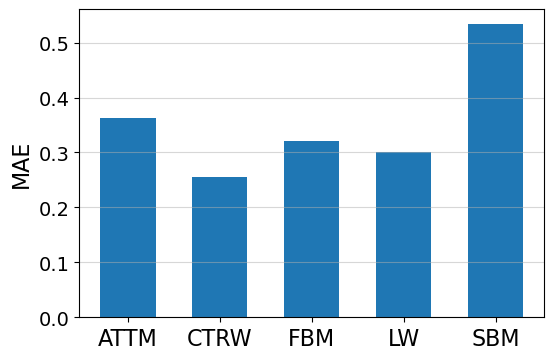

In [ ]:
x = np.arange(5)
plt.figure(figsize=(6, 4))
plt.bar(x, mae_by_model, width=0.6)
plt.grid(axis='y', alpha=0.5)
plt.ylabel('MAE', fontsize=16)
plt.xticks(x, [MODEL_DATA[n]['name'].upper() for n in x])
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=14)

### MAE by $\alpha$ in SBM

We see that SBM is a clear winner in terms of error. We further investigate the reasons behind it.

In [ ]:
ds_sbm = ds_segment[(ds_segment.model == 4)].reset_index(drop=True)
lengths_sbm = ds_sbm.length.unique()
lengths_sbm.sort()
mae_sbm_by_length = np.array([ds_sbm[ds_sbm.length == l].mae.mean() for l in lengths_sbm])
sem_sbm_by_length = np.array([ds_sbm[ds_sbm.length == l].mae.sem() for l in lengths_sbm])

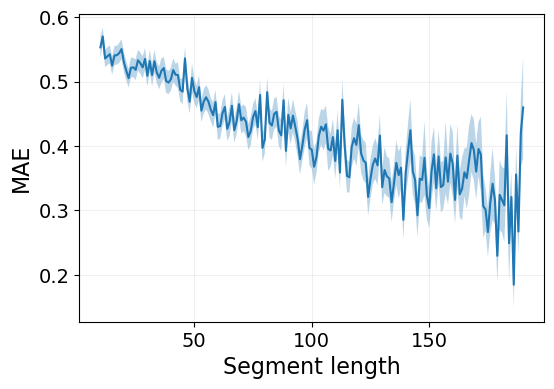

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(lengths_sbm, mae_sbm_by_length)
plt.fill_between(lengths_sbm.astype(float), mae_sbm_by_length - sem_sbm_by_length,
                 mae_sbm_by_length + sem_sbm_by_length, alpha=0.3)
plt.xlabel("Segment length", fontsize=16)
plt.ylabel("MAE", fontsize=16)
plt.tick_params(labelsize=14)
plt.grid(alpha=alpha_grid)

In [ ]:
ds_sbm['y_single'] = ds_sbm.y.apply(lambda x: x[0].item())
alphas_sbm = ds_sbm.y_single.unique()
alphas_sbm.sort()
mae_sbm_by_alpha = np.array([ds_sbm[ds_sbm.y_single == a].mae.mean() for a in alphas_sbm])
sem_sbm_by_alpha = np.array([ds_sbm[ds_sbm.y_single == a].mae.sem() for a in alphas_sbm])

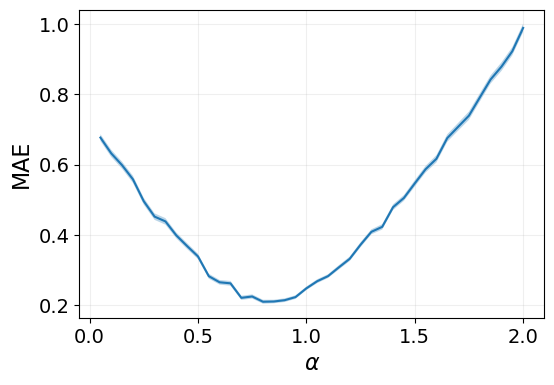

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(alphas_sbm, mae_sbm_by_alpha)
plt.fill_between(alphas_sbm.astype(float), mae_sbm_by_alpha - sem_sbm_by_alpha,
                 mae_sbm_by_alpha + sem_sbm_by_alpha, alpha=0.3)
plt.xlabel(r"$\alpha$", fontsize=16)
plt.ylabel("MAE", fontsize=16)
plt.tick_params(labelsize=14)
plt.grid(alpha=alpha_grid)

In [ ]:
ds_sbm['pred_single'] = ds_sbm.pred_cut.apply(lambda x: x.mean().item())

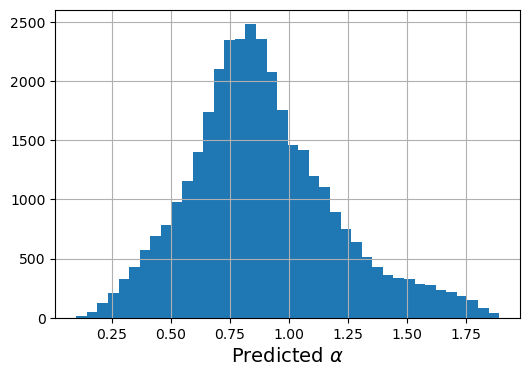

In [ ]:
plt.figure(figsize=(6, 4))
ds_sbm.pred_single.hist(bins=40)
plt.xlabel(r"Predicted $\alpha$", fontsize=14);

### MAE by noise and models

Finally, we look at the MAE by noise, as in Figure 4(b), but separated by diffusion models.

In [ ]:
fig_name = "noise_analysis_mae_models"
plot_path = (FIG_PATH/fig_name).with_suffix(".pkl")
with open(plot_path, 'rb') as f:
    mae_model_by_noise, bins_noise = pickle.load(f)

In [ ]:
dx = bins_noise[1] - bins_noise[0]
x_noise_model = bins_noise[:-1] + dx

## Plot MAE by model and noise

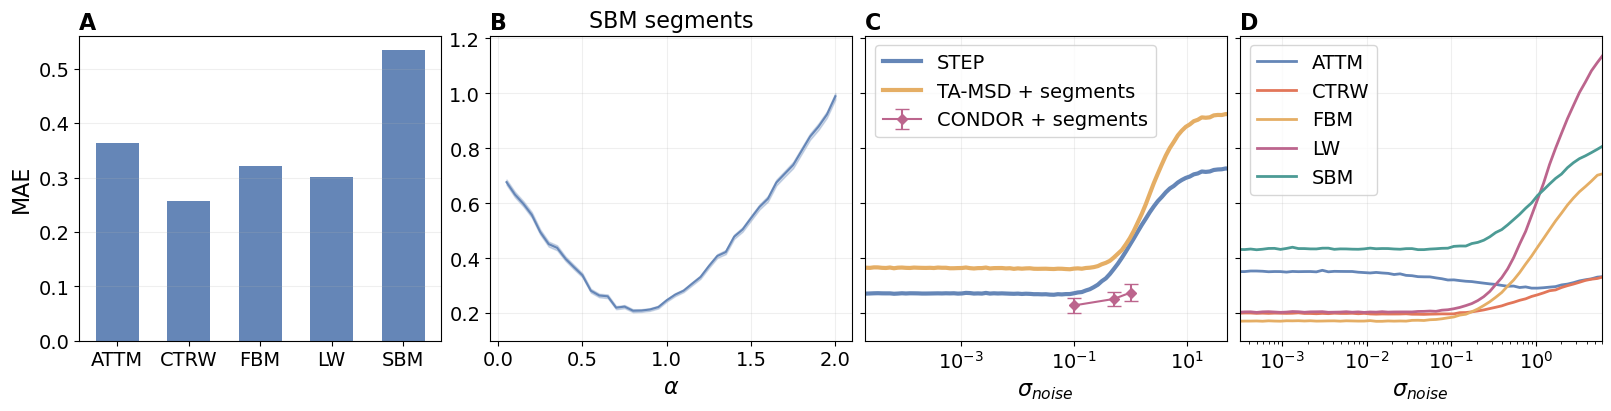

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(4*fig_size, fig_size), constrained_layout=True)

fontsize=16
ticksize=14

# MAE by models
x = np.arange(5)
ax[0].bar(x, mae_by_model, color=colors[0], width=0.6)
ax[0].grid(axis='y', alpha=alpha_grid)
ax[0].set_ylabel('MAE', fontsize=fontsize)
ax[0].set_xticks(x, [MODEL_DATA[n]['name'].upper() for n in x])

# MAE by alpha
ax[1].plot(alphas_sbm, mae_sbm_by_alpha, color=colors[0])
ax[1].fill_between(alphas_sbm.astype(float), mae_sbm_by_alpha - sem_sbm_by_alpha,
                 mae_sbm_by_alpha + sem_sbm_by_alpha, color=colors[0], alpha=0.3)
ax[1].set_xlabel(r"$\alpha$", fontsize=fontsize)
ax[1].set_title("SBM segments", fontsize=fontsize)

# MAE by noise
marker_condor, marker_size = 'D', 5
labels = ['STEP', 'TA-MSD + segments', 'CONDOR + segments']
idx = [0, 3]
for i, (err, s) in enumerate(zip(noise_err.T[idx], sem.T[idx])):
    ax[2].semilogx(10**x_err, err, '-', linewidth=3., color=colors[2*i], label=labels[i])
    ax[2].fill_between(10**x_err, err - s, err + s, color=colors[2*i], alpha=0.3)
ax[2].errorbar(condor_noises, condor_mae_noise, yerr=condor_sem_noise, capsize=5,
               marker=marker_condor, ms=marker_size, color=colors[3], label=labels[-1])
ax[2].legend(fontsize=ticksize)
ax[2].set_xlabel(r"$\sigma_{noise}$", fontsize=fontsize)
ax[2].set_xlim([2e-5, 50])
ax[2].set_yticklabels([])

# MAE by noise and model
for i, (m, mae) in enumerate(mae_model_by_noise.items()):
    ax[3].semilogx(10**x_noise_model, mae, linewidth=2, color=colors[i], label=m.upper())
ax[3].set_xlim([10**(-3.5), 6])
ax[3].legend(fontsize=ticksize)
ax[3].set_xlabel(r"$\sigma_{noise}$", fontsize=fontsize)
ax[3].set_yticklabels([])

# GENERAL

plt.setp(ax[1:], ylim=(0.1, 1.21))
for i, (a, let) in enumerate(zip(ax, 'ABCD')):
    a.annotate(let, (0, 1.02), xycoords='axes fraction', weight='bold', fontsize=fontsize)
    a.tick_params(labelsize=ticksize)
    if i != 0: a.grid(alpha=alpha_grid)
    
# plt.savefig(FIG_PATH/f'appendix_mae_model_noise.pdf', bbox_inches='tight', transparent=True)

## Predicted vs true alpha

In [ ]:
fig_name = "pred_vs_true_models_2"
with open(FIG_PATH/f'{fig_name}.pkl', 'rb') as f:
    pred_vs_true_by_model, noise_ranges, bins_by_model = pickle.load(f)

Then we retrieve the model indices by name from the `MODEL_DATA`.

In [ ]:
model_keys = {v['name']: k for k, v in MODEL_DATA.items()}
model_keys

{'attm': 0, 'ctrw': 1, 'fbm': 2, 'lw': 3, 'sbm': 4}

Finally, we define the maximum values in the color maps to ease the visual interpretation of the figures.

In [ ]:
vmax = {'attm': [0.9, 0.9, 0.9],
        'ctrw': [0.8, 0.9, 0.8],
        'fbm':  [0.3, 0.3, 0.5],
        'lw':   [0.6, 0.6, 0.6],
        'sbm':  [0.9, 0.9, 1]}

### Plot it!

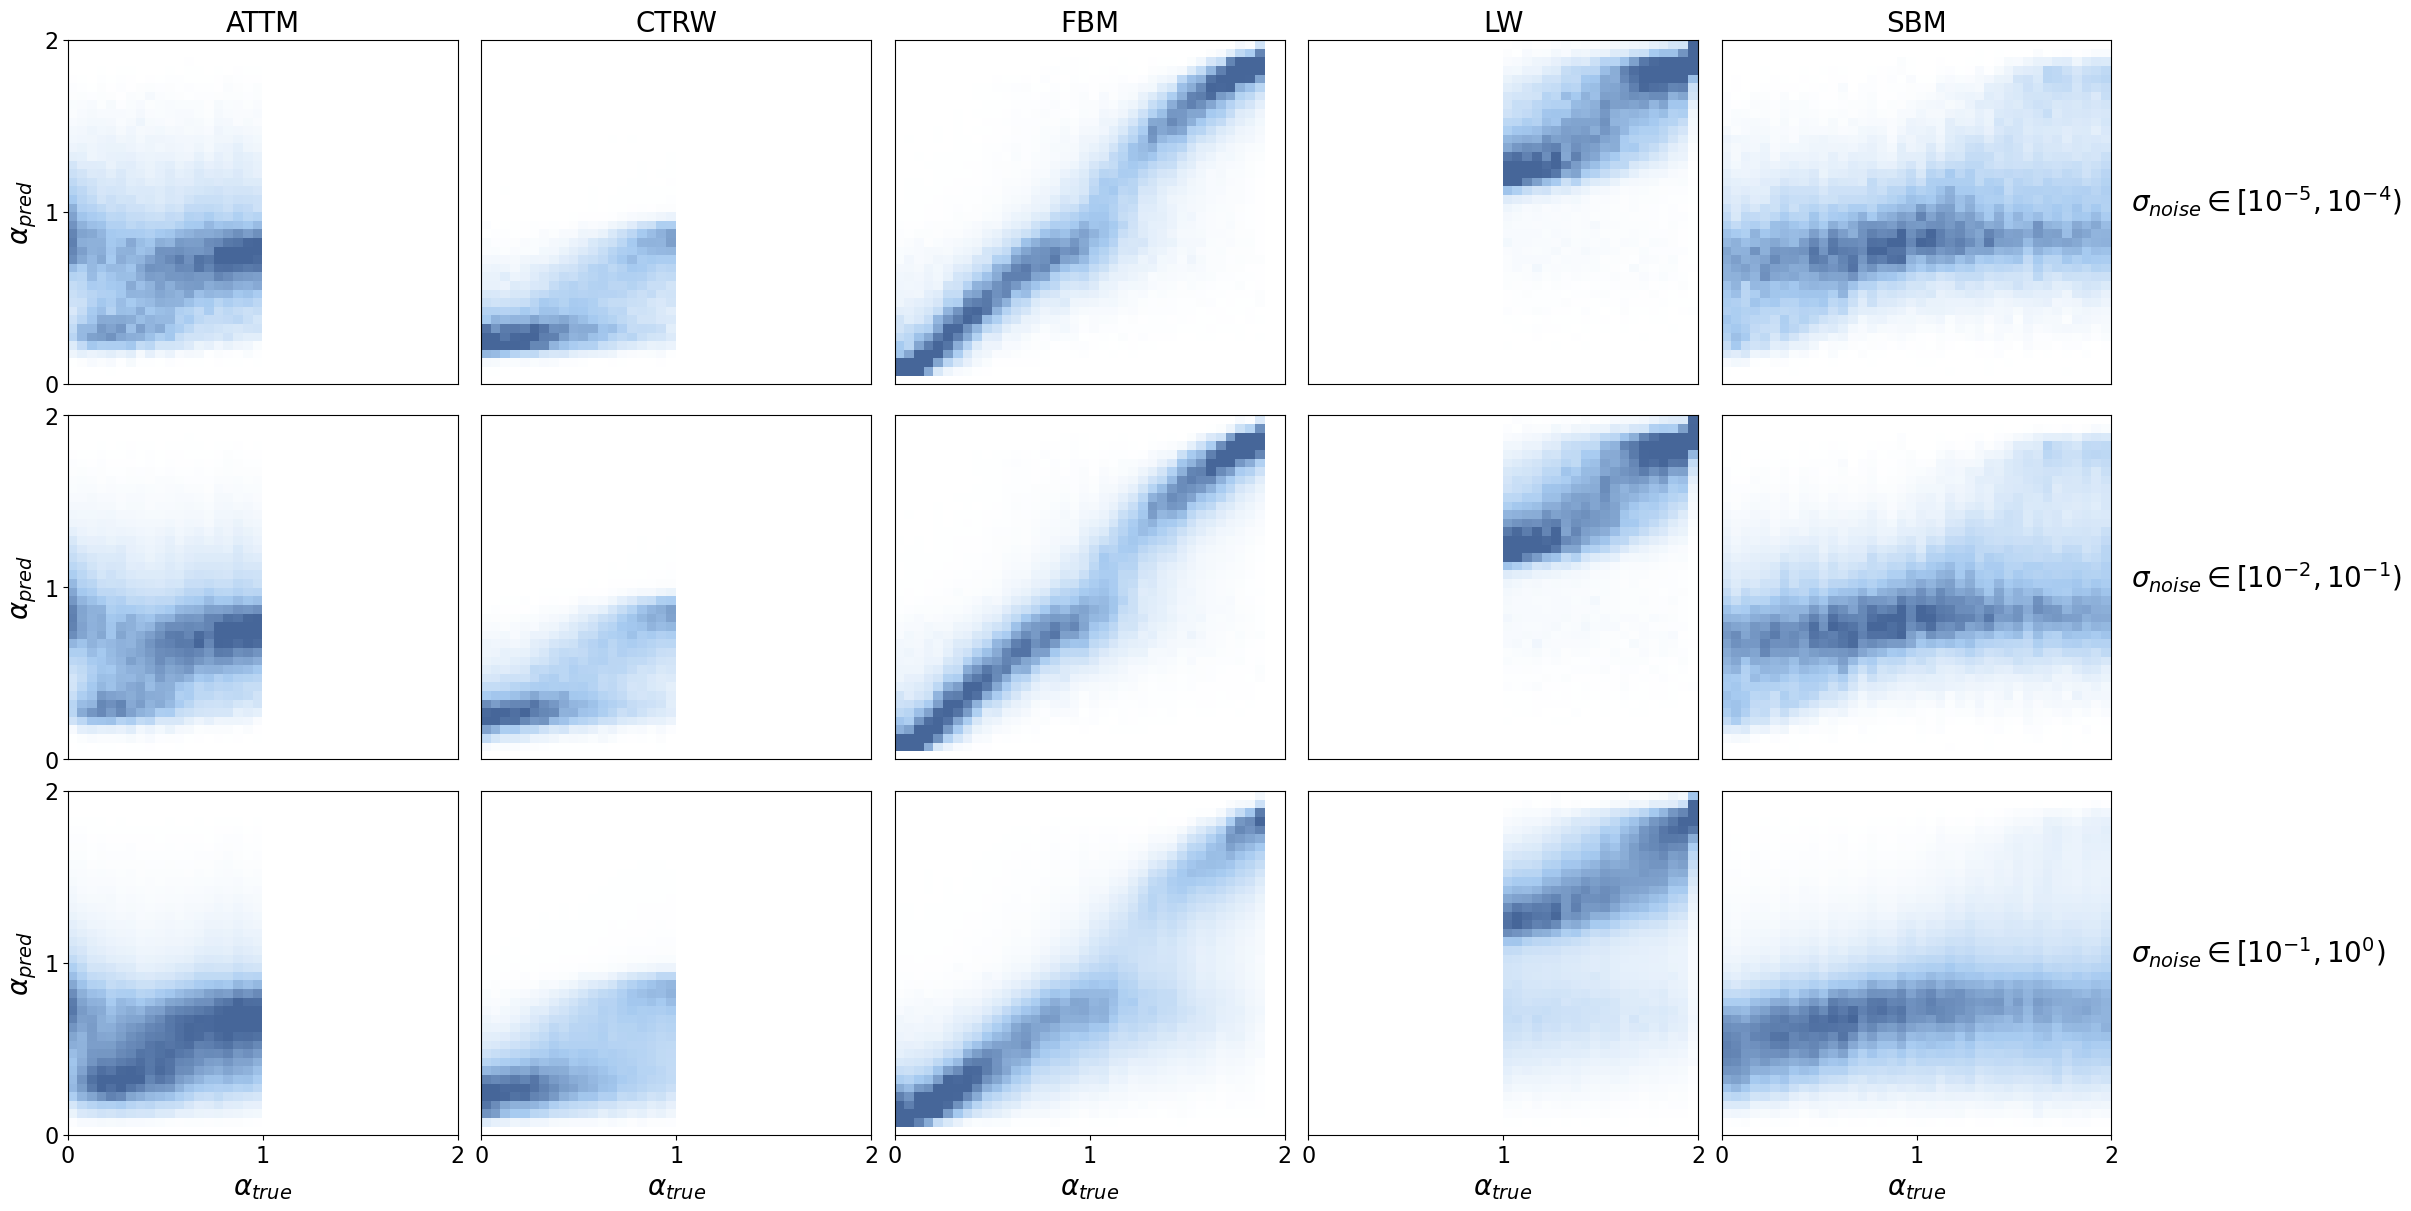

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(6*fig_size, 3*fig_size), constrained_layout=True)
ticks = (np.arange(0, bins_by_model['all'][-1], 20), [0, 1, 2])
ticksize = 16
fontsize = 20
noise_ranges = ["$[10^{-5}, 10^{-4})$", "$[10^{-2}, 10^{-1})$", "$[10^{-1}, 10^{0})$"]

for m, data in pred_vs_true_by_model.items():
    if m == 'all': continue
    m_axes = axes[:, model_keys[m]]
    hist, true_edges, pred_edges = data['hist'], data['true_edges'], data['pred_edges']
    for i, ax in enumerate(m_axes):
        shape = hist[i].shape
        ax.pcolor(hist[i].T/hist[i].max(), vmin=0, vmax=vmax[m][i],
                  cmap=cmap_hist1, rasterized=True)
        
        if i == 0:
            ax.set_title(m.upper(), fontsize=fontsize)
            ax.tick_params(labeltop=False)
        if i == 1:
            ax.tick_params(labeltop=False)
            
        if i == 2:
            ax.set_xticks(*ticks)
            ax.set_xlabel(r'$\alpha_{true}$', fontsize=fontsize)
            ax.tick_params(labeltop=False, labelbottom=True)
        else:
            ax.set_xticks([])
            
        if model_keys[m] == 0: 
            ax.set_ylabel(r'$\alpha_{pred}$', fontsize=fontsize)
            ax.set_yticks(*ticks)
        else:
            ax.set_yticks([])
        
        ax.tick_params(labelsize=ticksize);
        
    if m == 'sbm':
        for ax, noise in zip(m_axes, noise_ranges):
            ax.text(42, 20, fr"$\sigma_{{noise}} \in$" + noise, fontsize=fontsize)
# plt.savefig(FIG_PATH/f'appendix_alpha_pred_vs_true.pdf', bbox_inches='tight', transparent=True)

# Leftovers

## Old accuracy
### Example

We make up a toy example with representative errors to demonstrate the accuracy metric (find an extended explanation in 01_analysis_bm.ipynb).

In [ ]:
def detection_accuracy(pred, y, cp, return_mask=False):
    "Computes the number of points properly assigned to the true diffusion mode."
    cp = [0] + list(cp) + [y.shape[0]]
    slices = [slice(cp[c], cp[c+1]) for c in range(len(cp)-1)]
    modes = y[cp[:-1]]
        
    def _argmin_dist(x0, x1): return np.abs(x0[None] - x1[:, None]).argmin(0)
    
    correct_mask = [_argmin_dist(pred[s], modes[max(i-1, 0):i+2]) == (0 if i == 0 else 1)
                    for i, s in enumerate(slices)]
    rate = np.concatenate(correct_mask).mean()
    if return_mask: return rate, np.concatenate(correct_mask)
    return rate

Let's now define a synthetic ground truth with a prediction.

In [ ]:
# np.random.seed(0)
# D_example, lengths_example = [-1.85, 0.6, 0., -0.45], [8, 7, 6, 4]
# offsets = [-0.15, 0.1, -0.05, 0.4]
# true_example = np.concatenate([[val]*length for val, length in zip(D_example, lengths_example)])
# pred_example = np.concatenate([[val + o]*length for val, length, o in zip(D_example, lengths_example, offsets)])
# pred_example += np.random.randn(*pred_example.shape)*2e-2
# pred_example[lengths_example[0] - 1] += 2.1
# pred_example[lengths_example[0] - 2] += 0.55
# pred_example[sum(lengths_example[:2])] += 0.6
# x_example = np.arange(len(true_example))

In [ ]:
np.random.seed(0)
D_example, lengths_example = [-1.85, 0.6], [5, 6]
offsets = [-0.15, 0.1]
true_example = np.concatenate([[val]*length for val, length in zip(D_example, lengths_example)])
pred_example = np.concatenate([[val + o]*length for val, length, o in zip(D_example, lengths_example, offsets)])
pred_example += np.random.randn(*pred_example.shape)*1e-1
pred_example[lengths_example[0] - 1] += 2.1
pred_example[lengths_example[0] - 2] += 0.55
x_example = np.arange(len(true_example))

Let's obtain the accuracy with the correct mask for this example.

In [ ]:
cp_example = np.cumsum(lengths_example)[:-1]
acc_example, mask_example = detection_accuracy(pred_example, true_example, cp_example, return_mask=True)

### Accuracy as function of the change point position

For the following two plots, we load the data with just one change point. It may take a bit to load, but it's worth two plots ;)

In [ ]:
# We overdid it a bit with the amount of data sorry! >.<
ds_1cp_path = DATA_PATH/"bmds_1change_dim2_with_preds.pkl"
ds_1cp = pd.read_pickle(ds_1cp_path)

In this plot, we are interested in the effect of the position. We define intervals of 10 points over which we will compute the mean accuracy.

In [ ]:
bin_size = 10
bins_pos = np.arange(ds_1cp.cp.min(), ds_1cp.cp.max() + bin_size, bin_size)

We not only consider the full trajectory, but also the segregated predictions over the first and second segments of the trajectories.

In [ ]:
shape = len(bins_pos) - 1
acc_by_position, err_by_position = np.zeros(shape), np.zeros(shape)
acc0_by_position, err0_by_position = np.zeros(shape), np.zeros(shape)
acc1_by_position, err1_by_position = np.zeros(shape), np.zeros(shape)

for b, (b_low, b_high) in enumerate(zip(bins_pos[:-1], bins_pos[1:])):
    mask = (ds_1cp.cp >= b_low) & (ds_1cp.cp < b_high)
    acc_by_position[b] = ds_1cp.detect_rate[mask].mean()
    err_by_position[b] = ds_1cp.detect_rate[mask].sem()
    acc0_by_position[b] = ds_1cp.rate_0[mask].mean()
    err0_by_position[b] = ds_1cp.rate_0[mask].sem()
    acc1_by_position[b] = ds_1cp.rate_1[mask].mean()
    err1_by_position[b] = ds_1cp.rate_1[mask].sem()

### Accuracy as function of diffusion coefficient difference

Here, we do not need to load any additional data, as we have it already from the previous subfigure. We simply need to compute the desired metrics. 

In this case, we will perform an analogous binning to the change point position focusing in the difference between diffusino coefficents instead. We consider the difference in log-scale, which corresponds to the ratio between coefficients. 

In [ ]:
bins_diff = np.linspace(-6, 6, 241)
bin_size = bins_diff[1:] - bins_diff[:-1]
x_diff = 10**(bins_diff[:-1] + bin_size/2)

In [ ]:
acc_by_diff = np.array([ds_1cp.detect_rate[(ds_1cp.D_diff >= b_low) & (ds_1cp.D_diff < b_high)].mean()
                        for b_low, b_high in zip(bins_diff[:-1], bins_diff[1:])])
err_by_diff = np.array([ds_1cp.detect_rate[(ds_1cp.D_diff >= b_low) & (ds_1cp.D_diff < b_high)].sem()
                        for b_low, b_high in zip(bins_diff[:-1], bins_diff[1:])])

### Plot accuracy

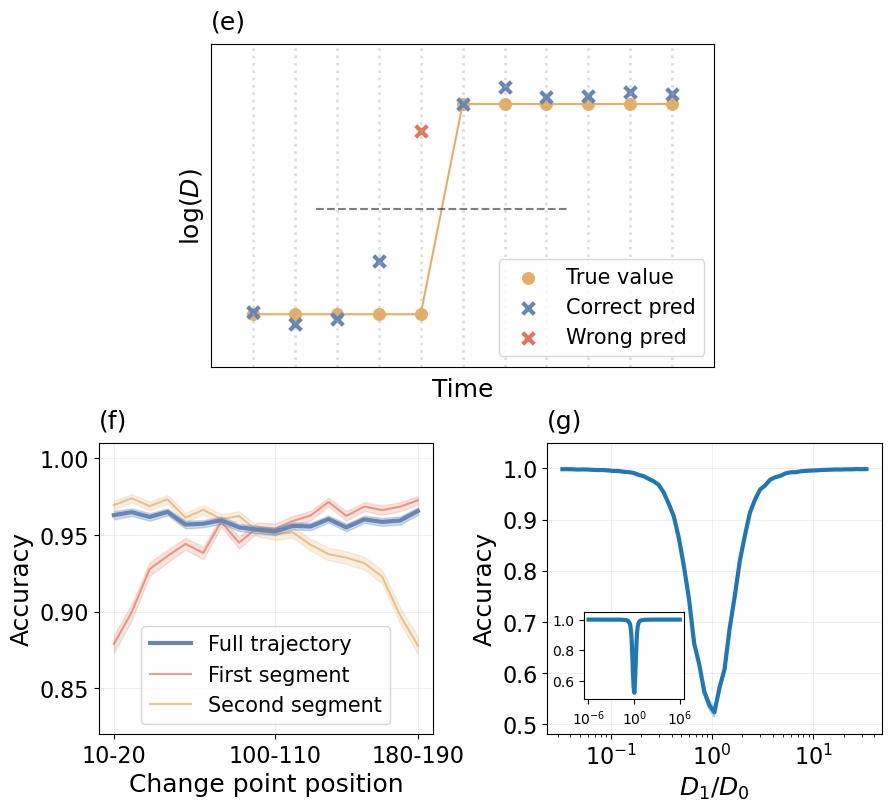

In [ ]:
fig = plt.figure(figsize=(2.2*fig_size, 2*fig_size), constrained_layout=True)
fontsize = 18
ticksize = 16

gs = fig.add_gridspec(2)
gs_top = gs[0].subgridspec(1, 5)
gs_bot = gs[1].subgridspec(1, 2, wspace=0)

# TOY EXAMPLE
ax0 = fig.add_subplot(gs_top[0, 1:-1])
ax0.scatter(x_example, true_example, s=70, color=colors[2], label='True value')
ax0.plot(x_example, true_example, color=colors[2], zorder=-1)
ax0.scatter(x_example, np.ma.masked_where(~mask_example, pred_example), s=70, color=colors[0],
            marker='x', linewidths=3, label='Correct pred')
ax0.scatter(x_example, np.ma.masked_where(mask_example, pred_example), s=70, color=colors[1],
            marker='x', linewidths=3, label='Wrong pred')
thresholds = np.array(D_example[:-1]) + 0.5*np.diff(D_example)
spans = [(l-3.5, l+2.5) for l in np.cumsum(lengths_example[:-1])]
for thresh, span in zip(thresholds, spans):
    ax0.hlines(thresh, *span, linestyles='dashed', alpha=0.5, color='k')
ax0.legend(loc='lower right', fontsize=ticksize-1)
ax0.set_ylabel(r"$\log(D)$", fontsize=fontsize)
ax0.set_xlabel("Time", fontsize=fontsize)
ax0.set_xlim([-1, x_example[-1]+1])
ax0.set_ylim([pred_example.min() - 0.5, pred_example.max() + 0.5])
ax0.set_xticks(x_example, labels=[])
ax0.set_yticks([])

# POSITION
ax1 = fig.add_subplot(gs_bot[0, 0])
ax1.plot(bins_pos[:-1], acc_by_position, linewidth=3, ms=8, color=colors[0],
           label="Full trajectory", zorder=6)
ax1.fill_between(bins_pos[:-1], acc_by_position - err_by_position, acc_by_position + err_by_position,
                   color=colors[0], alpha=0.3, zorder=5)
ax1.plot(bins_pos[:-1], acc0_by_position, alpha=0.7, color=colors[1], label="First segment", 
           zorder=4)
ax1.fill_between(bins_pos[:-1], acc0_by_position - err0_by_position, acc0_by_position + err0_by_position,
                   color=colors[1], alpha=0.2, zorder=2)
ax1.plot(bins_pos[:-1], acc1_by_position, alpha=0.7, color=colors[2], label="Second segment",
          zorder=3)
ax1.fill_between(bins_pos[:-1], acc1_by_position - err1_by_position, acc1_by_position + err1_by_position,
                   color=colors[2], alpha=0.2, zorder=1)
idx_ticks = np.array([0, len(bins_pos)//2, -2])
ax1.set_xticks(bins_pos[idx_ticks], [f'{b0}-{b1}' for b0, b1
                                       in zip(bins_pos[idx_ticks], bins_pos[idx_ticks + 1])])
ax1.set_xlabel("Change point position", fontsize=fontsize)
ax1.set_ylabel("Accuracy", fontsize=fontsize)
ax1.legend(fontsize=ticksize-1)
ax1.set_ylim([0.82, 1.01])

# DIFFERENCE
ax2 = fig.add_subplot(gs_bot[0, 1])
threshold = 1.5 # log10(D1/D0)
mask = (bins_diff[:-1] >= -threshold) & (bins_diff[:-1] <= threshold)
x_plt, y_plt, e_plt = x_diff[mask], acc_by_diff[mask], err_by_diff[mask]
ax2.semilogx(x_plt, y_plt, linewidth=3.)
ax2.fill_between(x_plt, y_plt - e_plt, y_plt + e_plt, alpha=0.3)

ax_ins = ax2.inset_axes([0.11, 0.12, 0.3, 0.3]) # x, y, w, h
ax_ins.semilogx(x_diff, acc_by_diff, linewidth=3.)
ax_ins.set_xticks([1e-6, 1e0, 1e6])
ax2.set_ylabel("Accuracy", fontsize=fontsize)
ax2.set_xlabel(r"$D_1/D_0$", fontsize=fontsize)
plt.setp([ax2, ax_ins], ylim=[0.48, 1.05])

for a, let in zip([ax0, ax1, ax2], 'efg'):
    a.annotate('('+let+')', (0, 1.05), xycoords='axes fraction', fontsize=fontsize)
    a.grid(alpha=alpha_grid)
    a.tick_params(labelsize=ticksize)
ax0.grid(axis='x', alpha=alpha_grid+0.2, linestyle='dotted', linewidth=linewidth)
ax0.tick_params(length=0)


# fig.savefig(FIG_PATH/'benchmark_right.pdf', transparent=True, bbox_inches=0);